In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from onestop.linear_mm_utils.calc_means_main import calc_mm_means_for_all_outcomes
from onestop.linear_mm_utils.julia_linear_mm import run_linear_mm
from plotly.subplots import make_subplots
from constants import (
    colors,
    outcome_name_mapping,
    outcome_units_mapping,
    re_columns,
    IA_REPORT_PATH,
)
from process_IA_rep_for_reread_analysis import (
    process_df_for_reread_analysis,
    upload,
)

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [3]:
data = pd.read_csv(
    "../" + IA_REPORT_PATH,
    engine="pyarrow",
)
# remove all columns with _Surprisal in them except for gpt2_Surprisal and prev_gpt2_Surprisal
cols_to_keep = ["gpt2_Surprisal", "prev_gpt2_Surprisal"]
cols_to_drop = [
    col for col in data.columns if "_Surprisal" in col and col not in cols_to_keep
]
data = data.drop(columns=cols_to_drop)

et_data_enriched = process_df_for_reread_analysis(data=data)

Exclude IAs
Adding paragraph_length column...
Splitting unique_paragraph_id to original columns
Adding add_first_read_out_of_2_column indicator column...
Adding experiment_IA_numbering indicator column...
Adding paragraph_numbering column...
Adding article_ind_diff_from_first_reading column for articles 11 and 12...
Adding variables indicating rereading trials with the same / different critical span as in the first reading


# Setup

In [5]:
et_data_enriched = et_data_enriched.query("IA_DWELL_TIME < 10000")

et_data_enriched["IA_ZERO_TF"] = et_data_enriched["IA_DWELL_TIME"] == 0

In [6]:
all_outcomes = [
    "IA_FIRST_FIXATION_DURATION",
    "IA_FIRST_RUN_DWELL_TIME",
    "IA_FIRST_PASS_GAZE_DURATION",
    "IA_RUN_COUNT",
    "IA_ZERO_TF",
    "IA_REGRESSION_OUT_FULL_COUNT",
]

## TFD, skip rate of 12th article ~ article_index of first reading


In [7]:
means_all_outcomes = calc_mm_means_for_all_outcomes(
    et_data_enriched.loc[lambda x: x["article_ind"] == 12].dropna(
        subset=["article_ind_of_first_reading"]
    ),  # type: ignore
    ["article_ind_of_first_reading", "has_preview"],
    re_columns,
    ["IA_DWELL_TIME", "IA_SKIP"],
    mean_mode="subset_mean",
)

outcome_variable: IA_DWELL_TIME
df_m shape before dropping nan: (151841, 110)
df_m shape after dropping nan: (151841, 110)
u_vals: ['1.0__Gathering', '1.0__Hunting', '2.0__Gathering', '2.0__Hunting', '3.0__Gathering', '3.0__Hunting', '4.0__Gathering', '4.0__Hunting', '5.0__Gathering', '5.0__Hunting', '6.0__Gathering', '6.0__Hunting', '7.0__Gathering', '7.0__Hunting', '8.0__Gathering', '8.0__Hunting', '9.0__Gathering', '9.0__Hunting']


100%|██████████| 18/18 [00:11<00:00,  1.53it/s]


outcome_variable: IA_SKIP
df_m shape before dropping nan: (151841, 110)
df_m shape after dropping nan: (151841, 110)
u_vals: ['1.0__Gathering', '1.0__Hunting', '2.0__Gathering', '2.0__Hunting', '3.0__Gathering', '3.0__Hunting', '4.0__Gathering', '4.0__Hunting', '5.0__Gathering', '5.0__Hunting', '6.0__Gathering', '6.0__Hunting', '7.0__Gathering', '7.0__Hunting', '8.0__Gathering', '8.0__Hunting', '9.0__Gathering', '9.0__Hunting']


100%|██████████| 18/18 [00:01<00:00, 17.56it/s]


In [8]:
# make article_ind_of_first_readingnumeric
means_all_outcomes["article_ind_of_first_reading"] = pd.to_numeric(
    means_all_outcomes["article_ind_of_first_reading"]
)
means_all_outcomes = means_all_outcomes.sort_values("article_ind_of_first_reading")

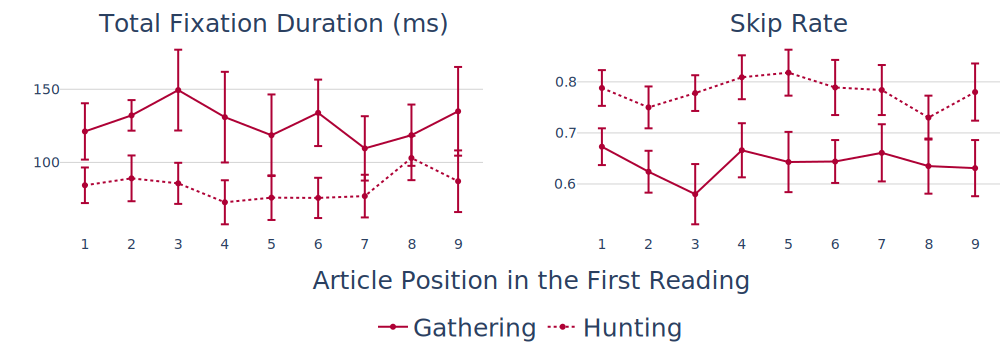

In [10]:
fig = make_subplots(
    rows=1,
    cols=2,
    subplot_titles=["Total Fixation Duration (ms)", "Skip Rate"],
    shared_xaxes=True,
    # shared_yaxes=True,
    x_title="Article Position in the First Reading",
    # y_title="Coefficient",
    vertical_spacing=0.05,
)

FR_RR_colors = colors[4:6]
for i, outcome in enumerate(["IA_DWELL_TIME", "IA_SKIP"]):
    means_outcome = means_all_outcomes.loc[lambda x: x["outcome_variable"] == outcome]
    hp_colors = [colors[1], colors[1]]
    # In the plot add 2 traces for read and reread with different hue
    for j, hp_val in enumerate(["Gathering", "Hunting"]):
        means_outcome_hp = means_outcome.loc[lambda x: (x["has_preview"] == hp_val)]

        means_outcome_non_consecutive = means_outcome_hp.loc[
            lambda x: x["article_ind_of_first_reading"] < 10
        ]
        fig.add_trace(
            go.Scatter(
                x=means_outcome_non_consecutive["article_ind_of_first_reading"],
                y=means_outcome_non_consecutive["mean"],
                error_y=dict(type="data", array=means_outcome_non_consecutive["2se"]),
                name=hp_val,
                marker=dict(color=hp_colors[j], symbol="circle"),
                showlegend=True if i == 0 else False,
                line=dict(dash="solid" if hp_val == "Gathering" else "dot"),
            ),
            row=1,
            col=i + 1,
        )
        if (
            len(means_outcome_hp.loc[lambda x: x["article_ind_of_first_reading"] == 10])
            > 0
        ):
            means_outcome_consecutive = means_outcome_hp.loc[
                lambda x: x["article_ind_of_first_reading"] == 10
            ]
            fig.add_trace(
                go.Scatter(
                    x=means_outcome_consecutive["article_ind_of_first_reading"],
                    y=means_outcome_consecutive["mean"],
                    error_y=dict(type="data", array=means_outcome_consecutive["2se"]),
                    name=hp_val + " (consecutive Repeated Reading)",
                    marker=dict(color=hp_colors[j], symbol="diamond"),
                    showlegend=True if i == 0 else False,
                    line=dict(dash="solid" if hp_val == "Gathering" else "dot"),
                ),
                row=1,
                col=i + 1,
            )

        fig.update_yaxes(
            title_text="",
            title_font=dict(size=25),
            tickfont=dict(size=14),
            row=1,
            col=i + 1,
        )
        # set the x axis to be the range of the article_ind
        fig.update_xaxes(
            # set the x values to [str(i) for i in range(1, 13)]
            tickvals=np.arange(1, 11),
            title_font=dict(size=25),
            tickfont=dict(size=14),
            row=1,
            col=i + 1,
        )

        fig.update_layout(
            plot_bgcolor="rgba(0,0,0,0)",
            # xaxis=dict(gridcolor="LightGray"),
            yaxis=dict(gridcolor="LightGray"),
        )

for i in [0, 1]:
    fig["layout"]["yaxis" + str(i + 1)]["showgrid"] = True  # type: ignore
    fig["layout"]["yaxis" + str(i + 1)]["gridcolor"] = "lightgray"  # type: ignore

fig.update_layout(
    height=350,
    width=1000,
)

# increse all font by 10
fig.update_layout(font=dict(size=25))
fig.update_annotations(font_size=25)

for i in range(2):
    # turn the grid background to white
    fig["layout"]["yaxis" + str(i + 1)]["showgrid"] = True  # type: ignore
    fig["layout"]["yaxis" + str(i + 1)]["gridcolor"] = "lightgray"  # type: ignore
# remove all margins
fig.update_layout(margin=dict(l=0, r=0, b=0, t=40, pad=0))
# move the legend to the bottom
fig = fig.update_layout(
    legend=dict(
        yanchor="bottom",
        y=-0.6,
        font=dict(size=25),
        orientation="h",
        x=0.5,
        xanchor="center",
    )
)

fig.show(renderer="svg")

In [13]:
upload(
    fig,
    "CogSci 2024 - Rereading",
    "main_figures/12th_means_by_FR_article_ind_TF_SR.pdf",
)

### SM - All outcomes


In [11]:
means_all_outcomes = calc_mm_means_for_all_outcomes(
    et_data_enriched.loc[lambda x: x["article_ind"] == 12].dropna(
        subset=["article_ind_of_first_reading"]
    ),  # type: ignore
    ["article_ind_of_first_reading", "has_preview"],
    re_columns,
    all_outcomes,
    mean_mode="subset_mean",
)

outcome_variable: IA_FIRST_FIXATION_DURATION
df_m shape before dropping nan: (151841, 110)
df_m shape after dropping nan: (151841, 110)
u_vals: ['1.0__Gathering', '1.0__Hunting', '2.0__Gathering', '2.0__Hunting', '3.0__Gathering', '3.0__Hunting', '4.0__Gathering', '4.0__Hunting', '5.0__Gathering', '5.0__Hunting', '6.0__Gathering', '6.0__Hunting', '7.0__Gathering', '7.0__Hunting', '8.0__Gathering', '8.0__Hunting', '9.0__Gathering', '9.0__Hunting']


100%|██████████| 18/18 [00:01<00:00, 17.77it/s]


outcome_variable: IA_FIRST_RUN_DWELL_TIME
df_m shape before dropping nan: (151841, 110)
df_m shape after dropping nan: (151841, 110)
u_vals: ['1.0__Gathering', '1.0__Hunting', '2.0__Gathering', '2.0__Hunting', '3.0__Gathering', '3.0__Hunting', '4.0__Gathering', '4.0__Hunting', '5.0__Gathering', '5.0__Hunting', '6.0__Gathering', '6.0__Hunting', '7.0__Gathering', '7.0__Hunting', '8.0__Gathering', '8.0__Hunting', '9.0__Gathering', '9.0__Hunting']


100%|██████████| 18/18 [00:01<00:00, 17.82it/s]


outcome_variable: IA_FIRST_PASS_GAZE_DURATION
df_m shape before dropping nan: (151841, 110)
df_m shape after dropping nan: (43518, 110)
u_vals: ['1.0__Gathering', '1.0__Hunting', '2.0__Gathering', '2.0__Hunting', '3.0__Gathering', '3.0__Hunting', '4.0__Gathering', '4.0__Hunting', '5.0__Gathering', '5.0__Hunting', '6.0__Gathering', '6.0__Hunting', '7.0__Gathering', '7.0__Hunting', '8.0__Gathering', '8.0__Hunting', '9.0__Gathering', '9.0__Hunting']


100%|██████████| 18/18 [00:01<00:00, 12.01it/s]


outcome_variable: IA_RUN_COUNT
df_m shape before dropping nan: (151841, 110)
df_m shape after dropping nan: (151841, 110)
u_vals: ['1.0__Gathering', '1.0__Hunting', '2.0__Gathering', '2.0__Hunting', '3.0__Gathering', '3.0__Hunting', '4.0__Gathering', '4.0__Hunting', '5.0__Gathering', '5.0__Hunting', '6.0__Gathering', '6.0__Hunting', '7.0__Gathering', '7.0__Hunting', '8.0__Gathering', '8.0__Hunting', '9.0__Gathering', '9.0__Hunting']


100%|██████████| 18/18 [00:01<00:00, 16.95it/s]


outcome_variable: IA_ZERO_TF
df_m shape before dropping nan: (151841, 110)
df_m shape after dropping nan: (151841, 110)
u_vals: ['1.0__Gathering', '1.0__Hunting', '2.0__Gathering', '2.0__Hunting', '3.0__Gathering', '3.0__Hunting', '4.0__Gathering', '4.0__Hunting', '5.0__Gathering', '5.0__Hunting', '6.0__Gathering', '6.0__Hunting', '7.0__Gathering', '7.0__Hunting', '8.0__Gathering', '8.0__Hunting', '9.0__Gathering', '9.0__Hunting']


100%|██████████| 18/18 [00:01<00:00,  9.96it/s]


outcome_variable: IA_REGRESSION_OUT_FULL_COUNT
df_m shape before dropping nan: (151841, 110)
df_m shape after dropping nan: (151841, 110)
u_vals: ['1.0__Gathering', '1.0__Hunting', '2.0__Gathering', '2.0__Hunting', '3.0__Gathering', '3.0__Hunting', '4.0__Gathering', '4.0__Hunting', '5.0__Gathering', '5.0__Hunting', '6.0__Gathering', '6.0__Hunting', '7.0__Gathering', '7.0__Hunting', '8.0__Gathering', '8.0__Hunting', '9.0__Gathering', '9.0__Hunting']


100%|██████████| 18/18 [00:01<00:00, 17.95it/s]


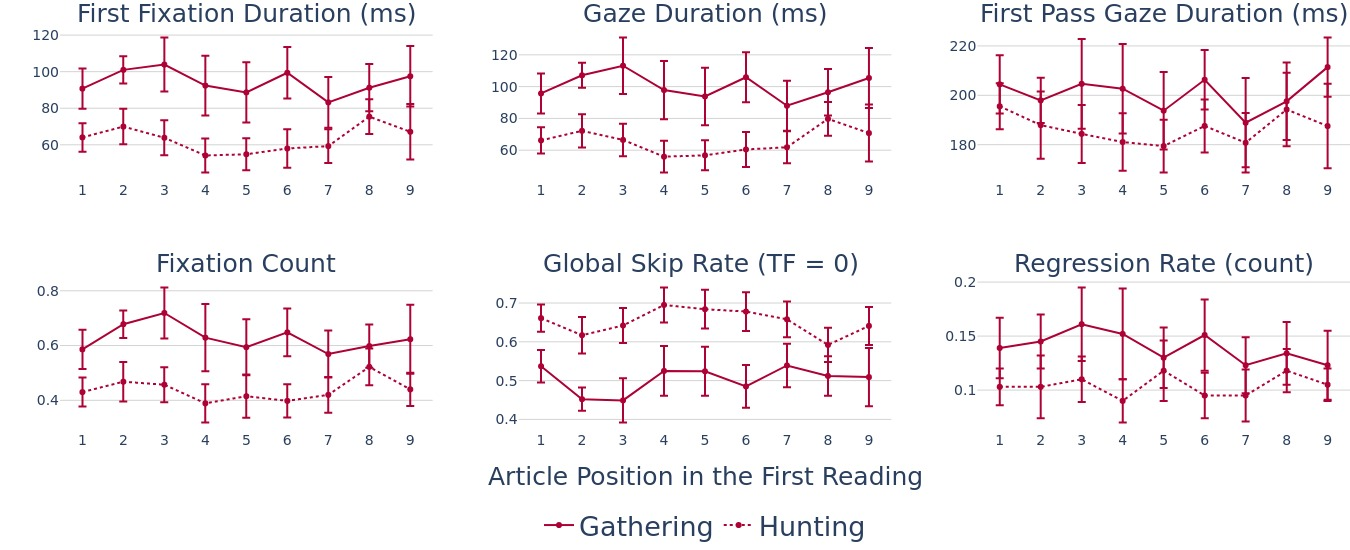

In [12]:
# turn article_ind_of_first_reading to ints
means_all_outcomes["article_ind_of_first_reading"] = pd.to_numeric(
    means_all_outcomes["article_ind_of_first_reading"]
)

fig = make_subplots(
    rows=2,
    cols=3,
    subplot_titles=tuple(
        [
            outcome_name_mapping[outcome]
            + (
                f" {outcome_units_mapping[outcome]}"
                if outcome not in ["IA_SKIP", "IA_RUN_COUNT"]
                else ""
            )
            for outcome in all_outcomes
        ]
    ),
    # shared_xaxes='rows',
    x_title="Article Position in the First Reading",
)

FR_RR_colors = colors[4:6]
for i, outcome in enumerate(all_outcomes):
    means_outcome = means_all_outcomes.loc[lambda x: x["outcome_variable"] == outcome]
    hp_colors = [colors[1], colors[1]]
    # In the plot add 2 traces for read and reread with different hue
    for j, hp_val in enumerate(["Gathering", "Hunting"]):
        means_outcome_hp = means_outcome.loc[lambda x: (x["has_preview"] == hp_val)]
        row = (i // 3) + 1
        col = (i % 3) + 1

        fig.add_trace(
            go.Scatter(
                x=means_outcome_hp["article_ind_of_first_reading"],
                y=means_outcome_hp["mean"],
                error_y=dict(type="data", array=means_outcome_hp["2se"]),
                name=hp_val,
                marker=dict(color=hp_colors[1]),
                showlegend=True if i == 0 else False,
                line=dict(dash="solid" if j == 0 else "dot"),
            ),
            row=row,
            col=col,
        )

        fig.update_layout(
            plot_bgcolor="rgba(0,0,0,0)",
            # xaxis=dict(gridcolor="LightGray"),
            yaxis=dict(gridcolor="LightGray"),
        )

        fig.update_yaxes(
            title_text="",
            title_font=dict(size=25),
            tickfont=dict(size=14),
            row=row,
            col=col,
        )

        fig.update_xaxes(
            title_text="",
            # set tickvalues to range(1, 10)
            tickvals=np.arange(1, 11),
            title_font=dict(size=25),
            tickfont=dict(size=14),
            row=row,
            col=col,
        )

for i in range(9):
    try:
        fig["layout"]["yaxis" + str(i + 1)]["showgrid"] = True  # type: ignore
        fig["layout"]["yaxis" + str(i + 1)]["gridcolor"] = "lightgray"  # type: ignore
    except:  # noqa: E722
        continue
# increse all font by 10
fig.update_layout(
    height=550,
    width=1350,
)
fig.update_layout(font=dict(size=25))
fig.update_annotations(font_size=25)

# change the tickfont of x to tickfont
fig.update_xaxes(tickfont=dict(size=14))

# remove all margins
fig.update_layout(margin=dict(l=0, r=0, b=0, t=30))
# move the legend to the bottom
fig = fig.update_layout(
    legend=dict(
        yanchor="bottom",
        y=-0.3,
        xanchor="center",
        x=0.5,
        font=dict(size=27),
        orientation="h",
    )
)

fig.show(renderer="jpg")

In [17]:
upload(
    fig,
    "CogSci 2024 - Rereading",
    "sm_figures/12th_means_by_FR_article_ind_all_outcomes.pdf",
)

## TFD, skip rate ~ article_index + same CS distinction (Excluded from the CogSci2024 version)


In [16]:
means_all_outcomes = calc_mm_means_for_all_outcomes(
    et_data_enriched,
    ["article_ind", "has_preview", "same_span_in_FR_also_gathering"],
    re_columns,
    ["IA_DWELL_TIME", "IA_SKIP"],
    mean_mode="subset_mean",
)

outcome_variable: IA_DWELL_TIME
df_m shape before dropping nan: (1824643, 110)
df_m shape after dropping nan: (1824643, 110)
u_vals: ['10__Gathering__.', '10__Hunting__.', '11__Gathering__False', '11__Gathering__True', '11__Hunting__False', '11__Hunting__True', '12__Gathering__False', '12__Gathering__True', '12__Hunting__False', '12__Hunting__True', '1__Gathering__.', '1__Hunting__.', '2__Gathering__.', '2__Hunting__.', '3__Gathering__.', '3__Hunting__.', '4__Gathering__.', '4__Hunting__.', '5__Gathering__.', '5__Hunting__.', '6__Gathering__.', '6__Hunting__.', '7__Gathering__.', '7__Hunting__.', '8__Gathering__.', '8__Hunting__.', '9__Gathering__.', '9__Hunting__.']


100%|██████████| 28/28 [00:05<00:00,  5.56it/s]


outcome_variable: IA_SKIP
df_m shape before dropping nan: (1824643, 110)
df_m shape after dropping nan: (1824643, 110)
u_vals: ['10__Gathering__.', '10__Hunting__.', '11__Gathering__False', '11__Gathering__True', '11__Hunting__False', '11__Hunting__True', '12__Gathering__False', '12__Gathering__True', '12__Hunting__False', '12__Hunting__True', '1__Gathering__.', '1__Hunting__.', '2__Gathering__.', '2__Hunting__.', '3__Gathering__.', '3__Hunting__.', '4__Gathering__.', '4__Hunting__.', '5__Gathering__.', '5__Hunting__.', '6__Gathering__.', '6__Hunting__.', '7__Gathering__.', '7__Hunting__.', '8__Gathering__.', '8__Hunting__.', '9__Gathering__.', '9__Hunting__.']


100%|██████████| 28/28 [00:04<00:00,  6.51it/s]


In [17]:
means_all_outcomes["article_ind"] = pd.to_numeric(means_all_outcomes["article_ind"])
means_all_outcomes.sort_values(
    by=["article_ind", "has_preview", "same_span_in_FR_also_gathering"], inplace=True
)

Gathering, First Reading
Gathering, First Reading - Same CS in First and Repeated Reading
Gathering, First Reading - Different CS in First and Repeated Reading
Hunting, First Reading
Hunting, First Reading - Same CS in First and Repeated Reading
Hunting, First Reading - Different CS in First and Repeated Reading
Gathering, First Reading
Gathering, First Reading - Same CS in First and Repeated Reading
Gathering, First Reading - Different CS in First and Repeated Reading
Hunting, First Reading
Hunting, First Reading - Same CS in First and Repeated Reading
Hunting, First Reading - Different CS in First and Repeated Reading


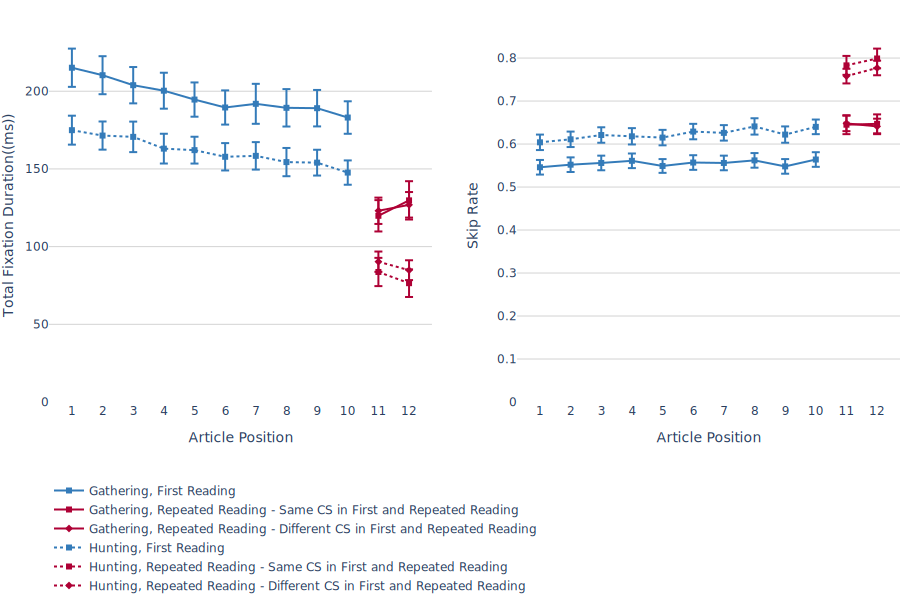

In [19]:
fig = make_subplots(
    rows=1,
    cols=2,
    # subplot_titles=("Total Fixation Duration", "Skip Rate"),
    vertical_spacing=0.1,
)

FR_RR_colors = colors[4:6]
for i, outcome in enumerate(["IA_DWELL_TIME", "IA_SKIP"]):
    means_outcome = means_all_outcomes.loc[lambda x: x["outcome_variable"] == outcome]
    hp_colors = colors[4:6]
    # In the plot add 2 traces for read and reread with different hue
    for j, hp_val in enumerate(["Gathering", "Hunting"]):
        for k, same_span_val in enumerate([".", "True", "False"]):
            means_outcome_hp = means_outcome.loc[
                lambda x: (x["has_preview"] == hp_val)
                & (x["same_span_in_FR_also_gathering"] == same_span_val)
            ]
            if len(means_outcome_hp) == 0:
                continue

            if same_span_val == "True":
                FR_CS_text = " - Same CS in First and Repeated Reading"
            elif same_span_val == "False":
                FR_CS_text = " - Different CS in First and Repeated Reading"
            elif same_span_val == ".":
                FR_CS_text = ""

            means_outcome_read = means_outcome_hp.loc[
                lambda x: x["article_ind"] <= 10
            ].sort_values(by="article_ind")
            means_outcome_reread = means_outcome_hp.loc[
                lambda x: x["article_ind"] > 10
            ].sort_values(by="article_ind")
            reread_symbol = (
                "square"
                if same_span_val == "True"
                else "diamond"
                if same_span_val == "False"
                else "circle"
            )
            print(hp_val + ", " + "First Reading" + FR_CS_text)
            if len(means_outcome_read) > 0:
                fig.add_trace(
                    go.Scatter(
                        x=means_outcome_read["article_ind"],
                        y=means_outcome_read["mean"],
                        error_y=dict(type="data", array=means_outcome_read["2se"]),
                        name=hp_val + ", " + "First Reading" + FR_CS_text,
                        marker=dict(
                            color=colors[0],
                            symbol="square",
                            # size=5
                        ),
                        showlegend=True if i == 0 else False,
                        line=dict(dash="solid" if j == 0 else "dot"),
                    ),
                    row=1,
                    col=i + 1,
                )
            if len(means_outcome_reread) > 0:
                if hp_val == "Gathering":
                    reread_color = colors[1]
                else:
                    reread_color = colors[1]

                fig.add_trace(
                    go.Scatter(
                        x=means_outcome_reread["article_ind"].to_list(),
                        y=means_outcome_reread["mean"].to_list(),
                        error_y=dict(type="data", array=means_outcome_reread["2se"]),
                        name=hp_val + ", " + "Repeated Reading" + FR_CS_text,
                        marker=dict(
                            color=reread_color,
                            symbol=reread_symbol,
                            # size=12 if reread_symbol != "circle" else 5,
                        ),
                        showlegend=True if i == 0 else False,
                        line=dict(dash="solid" if j == 0 else "dot"),
                    ),
                    row=1,
                    col=i + 1,
                )

            fig.update_xaxes(
                title_text="Article Position",
                # # set the font size of the title to 18
                # title_font=dict(size=35),
                # # set the tock font to 25
                # tickfont=dict(size=30),
                row=1,
                col=i + 1,
                # set the ticks to 1-12
                tickvals=np.arange(1, 13),
            )

            fig.update_layout(
                plot_bgcolor="rgba(0,0,0,0)",
                # xaxis=dict(gridcolor="LightGray"),
                yaxis=dict(gridcolor="LightGray"),
            )
            fig.update_yaxes(
                title_text=outcome_name_mapping[outcome]
                + (f"({outcome_units_mapping[outcome]})" if i == 0 else ""),
                # title_font=dict(size=38),
                # tickfont=dict(size=30),
                range=[0, "auto"],  # this line makes the y-axis start from 0
                row=1,
                col=i + 1,
            )
            fig.update_yaxes(rangemode="tozero")

for i in [0, 1]:
    # fig['layout']['xaxis' + str(i + 1)]['showgrid'] = True
    # fig['layout']['xaxis' + str(i + 1)]['gridcolor'] = 'lightgray'

    fig["layout"]["yaxis" + str(i + 1)]["showgrid"] = True  # type: ignore
    fig["layout"]["yaxis" + str(i + 1)]["gridcolor"] = "lightgray"  # type: ignore

fig.update_layout(
    height=600,
    width=900,
    # title_text="Means of Fixation Duration and Skip Rate by Article Index",
    # title_x=0.5,
    # font=dict(size=18),
)
# move the legend to the bottom
fig.update_layout(legend=dict(orientation="h", y=-0.2), yaxis_range=[0, "auto"])
# remove white margin
fig.update_layout(margin=dict(l=0, r=0, b=0, t=30))

# # increase the font size of the subplot titles
# fig.update_annotations(font_size=50)


fig.show(renderer="svg")

In [15]:
upload(fig, "CogSci 2024 - Rereading", "main_figures/1b.pdf")

Statistical test for differences - The p value table is the significance level of the difference between 2 consecutive values.


In [20]:
means_all_outcomes = calc_mm_means_for_all_outcomes(
    et_data_enriched,
    ["article_ind", "has_preview", "same_span_in_FR"],
    re_columns,
    all_outcomes,
    mean_mode="subset_mean",
)

outcome_variable: IA_FIRST_FIXATION_DURATION
df_m shape before dropping nan: (1824643, 110)
df_m shape after dropping nan: (1824643, 110)
u_vals: ['10__Gathering__.', '10__Hunting__.', '11__Gathering__.', '11__Hunting__False', '11__Hunting__True', '12__Gathering__.', '12__Hunting__False', '12__Hunting__True', '1__Gathering__.', '1__Hunting__.', '2__Gathering__.', '2__Hunting__.', '3__Gathering__.', '3__Hunting__.', '4__Gathering__.', '4__Hunting__.', '5__Gathering__.', '5__Hunting__.', '6__Gathering__.', '6__Hunting__.', '7__Gathering__.', '7__Hunting__.', '8__Gathering__.', '8__Hunting__.', '9__Gathering__.', '9__Hunting__.']


100%|██████████| 26/26 [00:05<00:00,  4.81it/s]


outcome_variable: IA_FIRST_RUN_DWELL_TIME
df_m shape before dropping nan: (1824643, 110)
df_m shape after dropping nan: (1824643, 110)
u_vals: ['10__Gathering__.', '10__Hunting__.', '11__Gathering__.', '11__Hunting__False', '11__Hunting__True', '12__Gathering__.', '12__Hunting__False', '12__Hunting__True', '1__Gathering__.', '1__Hunting__.', '2__Gathering__.', '2__Hunting__.', '3__Gathering__.', '3__Hunting__.', '4__Gathering__.', '4__Hunting__.', '5__Gathering__.', '5__Hunting__.', '6__Gathering__.', '6__Hunting__.', '7__Gathering__.', '7__Hunting__.', '8__Gathering__.', '8__Hunting__.', '9__Gathering__.', '9__Hunting__.']


100%|██████████| 26/26 [00:04<00:00,  5.28it/s]


outcome_variable: IA_FIRST_PASS_GAZE_DURATION
df_m shape before dropping nan: (1824643, 110)
df_m shape after dropping nan: (711388, 110)
u_vals: ['10__Gathering__.', '10__Hunting__.', '11__Gathering__.', '11__Hunting__False', '11__Hunting__True', '12__Gathering__.', '12__Hunting__False', '12__Hunting__True', '1__Gathering__.', '1__Hunting__.', '2__Gathering__.', '2__Hunting__.', '3__Gathering__.', '3__Hunting__.', '4__Gathering__.', '4__Hunting__.', '5__Gathering__.', '5__Hunting__.', '6__Gathering__.', '6__Hunting__.', '7__Gathering__.', '7__Hunting__.', '8__Gathering__.', '8__Hunting__.', '9__Gathering__.', '9__Hunting__.']


100%|██████████| 26/26 [00:02<00:00, 10.11it/s]


outcome_variable: IA_RUN_COUNT
df_m shape before dropping nan: (1824643, 110)
df_m shape after dropping nan: (1824643, 110)
u_vals: ['10__Gathering__.', '10__Hunting__.', '11__Gathering__.', '11__Hunting__False', '11__Hunting__True', '12__Gathering__.', '12__Hunting__False', '12__Hunting__True', '1__Gathering__.', '1__Hunting__.', '2__Gathering__.', '2__Hunting__.', '3__Gathering__.', '3__Hunting__.', '4__Gathering__.', '4__Hunting__.', '5__Gathering__.', '5__Hunting__.', '6__Gathering__.', '6__Hunting__.', '7__Gathering__.', '7__Hunting__.', '8__Gathering__.', '8__Hunting__.', '9__Gathering__.', '9__Hunting__.']


100%|██████████| 26/26 [00:04<00:00,  5.60it/s]


outcome_variable: IA_ZERO_TF
df_m shape before dropping nan: (1824643, 110)
df_m shape after dropping nan: (1824643, 110)
u_vals: ['10__Gathering__.', '10__Hunting__.', '11__Gathering__.', '11__Hunting__False', '11__Hunting__True', '12__Gathering__.', '12__Hunting__False', '12__Hunting__True', '1__Gathering__.', '1__Hunting__.', '2__Gathering__.', '2__Hunting__.', '3__Gathering__.', '3__Hunting__.', '4__Gathering__.', '4__Hunting__.', '5__Gathering__.', '5__Hunting__.', '6__Gathering__.', '6__Hunting__.', '7__Gathering__.', '7__Hunting__.', '8__Gathering__.', '8__Hunting__.', '9__Gathering__.', '9__Hunting__.']


100%|██████████| 26/26 [00:04<00:00,  5.80it/s]


outcome_variable: IA_REGRESSION_OUT_FULL_COUNT
df_m shape before dropping nan: (1824643, 110)
df_m shape after dropping nan: (1824643, 110)
u_vals: ['10__Gathering__.', '10__Hunting__.', '11__Gathering__.', '11__Hunting__False', '11__Hunting__True', '12__Gathering__.', '12__Hunting__False', '12__Hunting__True', '1__Gathering__.', '1__Hunting__.', '2__Gathering__.', '2__Hunting__.', '3__Gathering__.', '3__Hunting__.', '4__Gathering__.', '4__Hunting__.', '5__Gathering__.', '5__Hunting__.', '6__Gathering__.', '6__Hunting__.', '7__Gathering__.', '7__Hunting__.', '8__Gathering__.', '8__Hunting__.', '9__Gathering__.', '9__Hunting__.']


100%|██████████| 26/26 [00:04<00:00,  5.59it/s]


### Gathering


In [22]:
for outcome in ["IA_DWELL_TIME", "IA_SKIP"]:  # 15 mins each
    formula = f"{outcome} ~ 1 + article_ind + zerocorr(1 + article_ind | subject_id) + zerocorr(1 + article_ind | unique_paragraph_id)"
    coeff_table, _ = run_linear_mm(
        et_data_enriched[et_data_enriched["has_preview"] == "Gathering"],
        outcome,
        re_columns,
        formula,
        model_res_var_name="j_model",
        contrasts_dict={"article_ind": "SDC"},
        centralize_covariates=True,
        centralize_outcome=False,
        z_outcome=False,
        # link_dist=Bernoulli(),
        print_model_res=True,
    )  # Se   for the entire fue

Centralizing covariates:
Series([], dtype: float64)


JuliaError: MethodError: no method matching getindex(::PyPandasDataFrame, ::typeof(!), ::Symbol)
The function `getindex` exists, but no method is defined for this combination of argument types.
Stacktrace:
 [1] top-level scope
   @ none:3
 [2] eval
   @ ./boot.jl:430 [inlined]
 [3] eval
   @ ./Base.jl:130 [inlined]
 [4] pyjlmodule_seval(self::Module, expr::Py)
   @ PythonCall.JlWrap ~/.julia/packages/PythonCall/WMWY0/src/JlWrap/module.jl:13
 [5] _pyjl_callmethod(f::Any, self_::Ptr{PythonCall.C.PyObject}, args_::Ptr{PythonCall.C.PyObject}, nargs::Int64)
   @ PythonCall.JlWrap ~/.julia/packages/PythonCall/WMWY0/src/JlWrap/base.jl:67
 [6] _pyjl_callmethod(o::Ptr{PythonCall.C.PyObject}, args::Ptr{PythonCall.C.PyObject})
   @ PythonCall.JlWrap.Cjl ~/.julia/packages/PythonCall/WMWY0/src/JlWrap/C.jl:63

### Hunting Same CS (11 vs. 12)


In [ ]:
for outcome in ["IA_DWELL_TIME", "IA_SKIP"]:
    formula = f"{outcome} ~ 1 + article_ind + (1 + article_ind | subject_id) + (1 + article_ind | unique_paragraph_id)"
    coeff_table, _ = run_linear_mm(
        et_data_enriched[
            (et_data_enriched["has_preview"] == "Hunting")
            & (et_data_enriched["same_span_in_FR"] is True)
        ],
        outcome,
        re_columns,
        formula,
        model_res_var_name="j_model",
        contrasts_dict={"article_ind": "SDC"},
        centralize_covariates=True,
        centralize_outcome=False,
        z_outcome=False,
        print_model_res=True,
    )  # Se   for the entire fue

Centralizing covariates:
Series([], dtype: float64)
<PyCall.jlwrap Linear mixed model fit by maximum likelihood
 IA_DWELL_TIME ~ 1 + article_ind + (1 + article_ind | subject_id) + (1 + article_ind | unique_paragraph_id)
    logLik     -2 logLik       AIC         AICc          BIC     
 -230888.4163  461776.8325  461794.8325  461794.8375  461871.3150

Variance components:
                         Column      Variance  Std.Dev.   Corr.
unique_paragraph_id (Intercept)        788.2142  28.0752
                    article_ind: 12   1810.6376  42.5516 +0.08
subject_id          (Intercept)       1093.1524  33.0629
                    article_ind: 12   2027.1535  45.0239 -0.07
Residual                             19424.6999 139.3725
 Number of obs: 36245; levels of grouping factors: 177, 162

  Fixed-effects parameters:
─────────────────────────────────────────────────────
                   Coef.  Std. Error      z  Pr(>|z|)
─────────────────────────────────────────────────────
(Intercept)   

### Hunting Different CS (11 vs. 12)


In [ ]:
for outcome in ["IA_DWELL_TIME", "IA_SKIP"]:
    formula = f"{outcome} ~ 1 + article_ind + (1 + article_ind | subject_id) + (1 + article_ind | unique_paragraph_id)"
    coeff_table, _ = run_linear_mm(
        et_data_enriched[
            (et_data_enriched["has_preview"] == "Hunting")
            & (et_data_enriched["same_span_in_FR"] is False)
        ],
        outcome,
        re_columns,
        formula,
        model_res_var_name="j_model",
        contrasts_dict={"article_ind": "SDC"},
        centralize_covariates=True,
        centralize_outcome=False,
        z_outcome=False,
        print_model_res=True,
    )  # Se   for the entire fue

Centralizing covariates:
Series([], dtype: float64)
<PyCall.jlwrap Linear mixed model fit by maximum likelihood
 IA_DWELL_TIME ~ 1 + article_ind + (1 + article_ind | subject_id) + (1 + article_ind | unique_paragraph_id)
    logLik     -2 logLik       AIC         AICc          BIC     
 -745269.7740 1490539.5481 1490557.5481 1490557.5496 1490644.4835

Variance components:
                         Column      Variance  Std.Dev.   Corr.
unique_paragraph_id (Intercept)        555.3613  23.5661
                    article_ind: 12    945.7865  30.7536 -0.12
subject_id          (Intercept)       1114.9681  33.3911
                    article_ind: 12   1127.1213  33.5726 -0.02
Residual                             22434.9121 149.7829
 Number of obs: 115785; levels of grouping factors: 324, 180

  Fixed-effects parameters:
──────────────────────────────────────────────────────
                    Coef.  Std. Error      z  Pr(>|z|)
──────────────────────────────────────────────────────
(Intercept

### All of Hunting


In [38]:
for outcome in ["IA_DWELL_TIME", "IA_SKIP"]:
    formula = f"{outcome} ~ 1 + article_ind + zerocorr(1 + article_ind | subject_id) + zerocorr(1 + article_ind | unique_paragraph_id)"
    coeff_table, _ = run_linear_mm(
        et_data_enriched[(et_data_enriched["has_preview"] == "Hunting")],
        outcome,
        re_columns,
        formula,
        model_res_var_name="j_model",
        contrasts_dict={"article_ind": "SDC"},
        centralize_covariates=True,
        centralize_outcome=False,
        z_outcome=False,
        print_model_res=True,
    )  # Se   for the entire fue

Centralizing covariates:
Series([], dtype: float64)
<PyCall.jlwrap Linear mixed model fit by maximum likelihood
 IA_DWELL_TIME ~ 1 + article_ind + zerocorr(1 + article_ind | subject_id) + zerocorr(1 + article_ind | unique_paragraph_id)
     logLik     -2 logLik        AIC           AICc          BIC      
 -6123834.2330 12247668.4659 12247742.4659 12247742.4690 12248176.2913

Variance components:
                         Column      Variance  Std.Dev.   Corr.
unique_paragraph_id (Intercept)        461.3445  21.4789
                    article_ind: 2    1612.9323  40.1613   .  
                    article_ind: 3    1363.4565  36.9250   .     .  
                    article_ind: 4     976.7428  31.2529   .     .     .  
                    article_ind: 5    1024.2986  32.0047   .     .     .     .  
                    article_ind: 6     839.4062  28.9725   .     .     .     .     .  
                    article_ind: 7     737.8079  27.1626   .     .     .     .     .     .  
           

### Hunting - 11 vs. 12 & Same CS vs. Different CS


In [39]:
sub_df = et_data_enriched[
    (et_data_enriched["has_preview"] == "Hunting")
    & (et_data_enriched["article_ind"] > 10)
]

for outcome in ["IA_DWELL_TIME", "IA_SKIP"]:
    formula = f"{outcome} ~ 1 + article_ind * same_span_in_FR + (1 + article_ind * same_span_in_FR | subject_id) + (1 + article_ind * same_span_in_FR | unique_paragraph_id)"
    coeff_table, _ = run_linear_mm(
        sub_df,
        outcome,
        re_columns,
        formula,
        model_res_var_name="j_model",
        centralize_covariates=False,
        centralize_outcome=False,
        z_outcome=False,
        print_model_res=True,
    )  # Se   for the entire fue

<PyCall.jlwrap Linear mixed model fit by maximum likelihood
 IA_DWELL_TIME ~ 1 + article_ind + same_span_in_FR + article_ind & same_span_in_FR + (1 + article_ind + same_span_in_FR + article_ind & same_span_in_FR | subject_id) + (1 + article_ind + same_span_in_FR + article_ind & same_span_in_FR | unique_paragraph_id)
    logLik     -2 logLik       AIC         AICc          BIC     
 -976249.2304 1952498.4607 1952548.4607 1952548.4693 1952796.7565

Variance components:
                                       Column                      Variance  Std.Dev.   Corr.
unique_paragraph_id (Intercept)                                   126153.1575 355.1805
                    article_ind                                      933.4770  30.5529 -1.00
                    same_span_in_FR: PyObject True                318549.9596 564.4023 -0.54 +0.54
                    article_ind & same_span_in_FR: PyObject True    2401.3098  49.0032 +0.54 -0.54 -1.00
subject_id          (Intercept)                   

### In 11 - Hunting - Same CS vs. Different CS


In [40]:
sub_df = et_data_enriched[
    (et_data_enriched["has_preview"] == "Hunting")
    & (et_data_enriched["same_span_in_FR"] != ".")
    & (et_data_enriched["article_ind"] == 11)
]

for outcome in ["IA_DWELL_TIME", "IA_SKIP"]:
    formula = f"{outcome} ~ 1 + same_span_in_FR + (1 + same_span_in_FR | subject_id) + (1 + same_span_in_FR | unique_paragraph_id)"
    coeff_table, _ = run_linear_mm(
        sub_df,
        outcome,
        re_columns,
        formula,
        model_res_var_name="j_model",
        centralize_covariates=False,
        centralize_outcome=False,
        z_outcome=False,
        print_model_res=True,
    )  # Se   for the entire fue

<PyCall.jlwrap Linear mixed model fit by maximum likelihood
 IA_DWELL_TIME ~ 1 + same_span_in_FR + (1 + same_span_in_FR | subject_id) + (1 + same_span_in_FR | unique_paragraph_id)
    logLik     -2 logLik       AIC         AICc          BIC     
 -489954.8044  979909.6087  979927.6087  979927.6111  980010.7506

Variance components:
                                Column              Variance  Std.Dev.   Corr.
unique_paragraph_id (Intercept)                       871.3094  29.5180
                    same_span_in_FR: PyObject True   1694.8851  41.1690 -0.59
subject_id          (Intercept)                      1411.8748  37.5749
                    same_span_in_FR: PyObject True   1078.6079  32.8422 -0.37
Residual                                            22984.3533 151.6059
 Number of obs: 75962; levels of grouping factors: 324, 180

  Fixed-effects parameters:
─────────────────────────────────────────────────────────────────────
                                   Coef.  Std. Error    

### In 12 - Hunting - Same CS vs. Different CS


In [41]:
sub_df = et_data_enriched[
    (et_data_enriched["has_preview"] == "Hunting")
    & (et_data_enriched["same_span_in_FR"] != ".")
    & (et_data_enriched["article_ind"] == 12)
]

for outcome in ["IA_DWELL_TIME", "IA_SKIP"]:
    formula = f"{outcome} ~ 1 + same_span_in_FR + (1 + same_span_in_FR | subject_id) + (1 + same_span_in_FR | unique_paragraph_id)"
    coeff_table, _ = run_linear_mm(
        sub_df,
        outcome,
        re_columns,
        formula,
        model_res_var_name="j_model",
        centralize_covariates=False,
        centralize_outcome=False,
        z_outcome=False,
        print_model_res=True,
    )  # Se   for the entire fue

<PyCall.jlwrap Linear mixed model fit by maximum likelihood
 IA_DWELL_TIME ~ 1 + same_span_in_FR + (1 + same_span_in_FR | subject_id) + (1 + same_span_in_FR | unique_paragraph_id)
    logLik     -2 logLik       AIC         AICc          BIC     
 -486223.1707  972446.3414  972464.3414  972464.3438  972547.4958

Variance components:
                                Column              Variance  Std.Dev.   Corr.
unique_paragraph_id (Intercept)                       731.2241  27.0412
                    same_span_in_FR: PyObject True   1786.1919  42.2634 -0.56
subject_id          (Intercept)                      1390.1363  37.2845
                    same_span_in_FR: PyObject True   1074.0144  32.7722 -0.42
Residual                                            20457.6225 143.0301
 Number of obs: 76068; levels of grouping factors: 324, 180

  Fixed-effects parameters:
─────────────────────────────────────────────────────────────────────
                                   Coef.  Std. Error    

### In 11 + 12 - Hunting - Same CS vs. Different CS


In [42]:
sub_df = et_data_enriched[
    (et_data_enriched["has_preview"] == "Hunting")
    & (et_data_enriched["article_ind"] > 10)
]

for outcome in ["IA_DWELL_TIME", "IA_SKIP"]:
    formula = f"{outcome} ~ 1 + same_span_in_FR + (1 + same_span_in_FR | subject_id) + (1 + same_span_in_FR | unique_paragraph_id)"
    coeff_table, _ = run_linear_mm(
        sub_df,
        outcome,
        re_columns,
        formula,
        model_res_var_name="j_model",
        centralize_covariates=False,
        centralize_outcome=False,
        z_outcome=False,
        print_model_res=True,
    )  # Se   for the entire fue

<PyCall.jlwrap Linear mixed model fit by maximum likelihood
 IA_DWELL_TIME ~ 1 + same_span_in_FR + (1 + same_span_in_FR | subject_id) + (1 + same_span_in_FR | unique_paragraph_id)
    logLik     -2 logLik       AIC         AICc          BIC     
 -977069.3024 1954138.6047 1954156.6047 1954156.6059 1954245.9912

Variance components:
                                Column              Variance  Std.Dev.   Corr.
unique_paragraph_id (Intercept)                       658.0713  25.6529
                    same_span_in_FR: PyObject True   1530.7063  39.1242 -0.55
subject_id          (Intercept)                      1209.6933  34.7806
                    same_span_in_FR: PyObject True    780.8383  27.9435 -0.25
Residual                                            22081.8323 148.5996
 Number of obs: 152030; levels of grouping factors: 324, 180

  Fixed-effects parameters:
─────────────────────────────────────────────────────────────────────
                                   Coef.  Std. Error   

## TFD, skip rate ~ article_index


In [12]:
means_all_outcomes = calc_mm_means_for_all_outcomes(
    et_data_enriched,
    ["article_ind", "has_preview"],
    re_columns,
    ["IA_DWELL_TIME", "IA_SKIP"],
    mean_mode="subset_mean",
)

outcome_variable: IA_DWELL_TIME
df_m shape before dropping nan: (1935078, 112)
df_m shape after dropping nan: (1935078, 112)
u_vals: ['10__Gathering', '10__Hunting', '11__Gathering', '11__Hunting', '12__Gathering', '12__Hunting', '1__Gathering', '1__Hunting', '2__Gathering', '2__Hunting', '3__Gathering', '3__Hunting', '4__Gathering', '4__Hunting', '5__Gathering', '5__Hunting', '6__Gathering', '6__Hunting', '7__Gathering', '7__Hunting', '8__Gathering', '8__Hunting', '9__Gathering', '9__Hunting']


100%|██████████| 24/24 [00:35<00:00,  1.47s/it]


outcome_variable: IA_SKIP
df_m shape before dropping nan: (1935078, 112)
df_m shape after dropping nan: (1935078, 112)
u_vals: ['10__Gathering', '10__Hunting', '11__Gathering', '11__Hunting', '12__Gathering', '12__Hunting', '1__Gathering', '1__Hunting', '2__Gathering', '2__Hunting', '3__Gathering', '3__Hunting', '4__Gathering', '4__Hunting', '5__Gathering', '5__Hunting', '6__Gathering', '6__Hunting', '7__Gathering', '7__Hunting', '8__Gathering', '8__Hunting', '9__Gathering', '9__Hunting']


100%|██████████| 24/24 [00:12<00:00,  1.87it/s]


In [13]:
means_all_outcomes["article_ind"] = pd.to_numeric(means_all_outcomes["article_ind"])

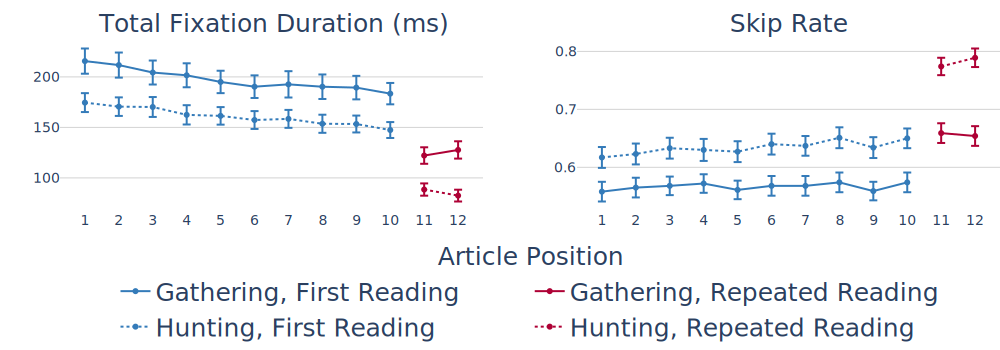

In [14]:
fig = make_subplots(
    rows=1,
    cols=2,
    subplot_titles=["Total Fixation Duration (ms)", "Skip Rate"],
    shared_xaxes=True,
    # shared_yaxes=True,
    x_title="Article Position",
    # y_title="Coefficient",
    vertical_spacing=0.05,
)

FR_RR_colors = colors[4:6]
for i, outcome in enumerate(["IA_DWELL_TIME", "IA_SKIP"]):
    means_outcome = means_all_outcomes.loc[lambda x: x["outcome_variable"] == outcome]
    hp_colors = colors[4:6]
    # In the plot add 2 traces for read and reread with different hue
    for j, hp_val in enumerate(["Gathering", "Hunting"]):
        means_outcome_hp = means_outcome.loc[lambda x: (x["has_preview"] == hp_val)]
        # print(means_outcome_hp)
        if len(means_outcome_hp) == 0:
            continue

        means_outcome_read = means_outcome_hp.loc[
            lambda x: x["article_ind"] <= 10
        ].sort_values(by="article_ind")
        means_outcome_reread = means_outcome_hp.loc[
            lambda x: x["article_ind"] > 10
        ].sort_values(by="article_ind")
        if len(means_outcome_read) > 0:
            fig.add_trace(
                go.Scatter(
                    x=means_outcome_read["article_ind"],
                    y=means_outcome_read["mean"],
                    error_y=dict(type="data", array=means_outcome_read["2se"]),
                    name=hp_val + ", " + "First Reading",
                    marker=dict(color=colors[0]),
                    showlegend=True if i == 0 else False,
                    line=dict(dash="solid" if j == 0 else "dot"),
                ),
                row=1,
                col=i + 1,
            )
        if len(means_outcome_reread) > 0:
            fig.add_trace(
                go.Scatter(
                    x=means_outcome_reread["article_ind"].to_list(),
                    y=means_outcome_reread["mean"].to_list(),
                    error_y=dict(type="data", array=means_outcome_reread["2se"]),
                    name=hp_val + ", " + "Repeated Reading",
                    marker=dict(color=colors[1]),
                    showlegend=True if i == 0 else False,
                    line=dict(dash="solid" if j == 0 else "dot"),
                ),
                row=1,
                col=i + 1,
            )

            fig.update_yaxes(
                title_text="",
                title_font=dict(size=25),
                tickfont=dict(size=14),
                row=1,
                col=i + 1,
            )
            # set the x axis to be the range of the article_ind
            fig.update_xaxes(
                # set the x values to [str(i) for i in range(1, 13)]
                tickvals=np.arange(1, 13),
                title_font=dict(size=25),
                tickfont=dict(size=14),
                row=1,
                col=i + 1,
            )

            fig.update_layout(
                plot_bgcolor="rgba(0,0,0,0)",
                # xaxis=dict(gridcolor="LightGray"),
                yaxis=dict(gridcolor="LightGray"),
            )

for i in [0, 1]:
    # fig['layout']['xaxis' + str(i + 1)]['showgrid'] = True
    # fig['layout']['xaxis' + str(i + 1)]['gridcolor'] = 'lightgray'

    fig["layout"]["yaxis" + str(i + 1)]["showgrid"] = True # type: ignore
    fig["layout"]["yaxis" + str(i + 1)]["gridcolor"] = "lightgray" # type: ignore

fig.update_layout(
    height=350,
    width=1000,
)

# increse all font by 10
fig.update_layout(font=dict(size=25))
fig.update_annotations(font_size=25)

for i in range(2):
    # turn the grid background to white
    fig["layout"]["yaxis" + str(i + 1)]["showgrid"] = True # type: ignore
    fig["layout"]["yaxis" + str(i + 1)]["gridcolor"] = "lightgray" # type: ignore
# remove all margins
fig.update_layout(margin=dict(l=0, r=0, b=0, t=40, pad=0))
# move the legend to the bottom
fig = fig.update_layout(
    legend=dict(
        yanchor="bottom",
        y=-0.82,
        xanchor="center",
        x=0.5,
        font=dict(size=25),
        orientation="h",
    )
)

fig.show(renderer="svg")

In [15]:
upload(fig, "CogSci 2024 - Rereading", "main_figures/means_by_article_ind.pdf")

### SM - All outcomes

In [16]:
means_all_outcomes = calc_mm_means_for_all_outcomes(
    et_data_enriched,
    ["article_ind", "has_preview"],
    re_columns,
    all_outcomes,
    mean_mode="subset_mean",
)

outcome_variable: IA_FIRST_FIXATION_DURATION
df_m shape before dropping nan: (1935078, 112)
df_m shape after dropping nan: (1935078, 112)
u_vals: ['10__Gathering', '10__Hunting', '11__Gathering', '11__Hunting', '12__Gathering', '12__Hunting', '1__Gathering', '1__Hunting', '2__Gathering', '2__Hunting', '3__Gathering', '3__Hunting', '4__Gathering', '4__Hunting', '5__Gathering', '5__Hunting', '6__Gathering', '6__Hunting', '7__Gathering', '7__Hunting', '8__Gathering', '8__Hunting', '9__Gathering', '9__Hunting']


100%|██████████| 24/24 [00:13<00:00,  1.72it/s]


outcome_variable: IA_FIRST_RUN_DWELL_TIME
df_m shape before dropping nan: (1935078, 112)
df_m shape after dropping nan: (1935078, 112)
u_vals: ['10__Gathering', '10__Hunting', '11__Gathering', '11__Hunting', '12__Gathering', '12__Hunting', '1__Gathering', '1__Hunting', '2__Gathering', '2__Hunting', '3__Gathering', '3__Hunting', '4__Gathering', '4__Hunting', '5__Gathering', '5__Hunting', '6__Gathering', '6__Hunting', '7__Gathering', '7__Hunting', '8__Gathering', '8__Hunting', '9__Gathering', '9__Hunting']


100%|██████████| 24/24 [00:13<00:00,  1.74it/s]


outcome_variable: IA_FIRST_PASS_GAZE_DURATION
df_m shape before dropping nan: (1935078, 112)
df_m shape after dropping nan: (732662, 112)
u_vals: ['10__Gathering', '10__Hunting', '11__Gathering', '11__Hunting', '12__Gathering', '12__Hunting', '1__Gathering', '1__Hunting', '2__Gathering', '2__Hunting', '3__Gathering', '3__Hunting', '4__Gathering', '4__Hunting', '5__Gathering', '5__Hunting', '6__Gathering', '6__Hunting', '7__Gathering', '7__Hunting', '8__Gathering', '8__Hunting', '9__Gathering', '9__Hunting']


100%|██████████| 24/24 [00:12<00:00,  1.88it/s]


outcome_variable: IA_RUN_COUNT
df_m shape before dropping nan: (1935078, 112)
df_m shape after dropping nan: (1935078, 112)
u_vals: ['10__Gathering', '10__Hunting', '11__Gathering', '11__Hunting', '12__Gathering', '12__Hunting', '1__Gathering', '1__Hunting', '2__Gathering', '2__Hunting', '3__Gathering', '3__Hunting', '4__Gathering', '4__Hunting', '5__Gathering', '5__Hunting', '6__Gathering', '6__Hunting', '7__Gathering', '7__Hunting', '8__Gathering', '8__Hunting', '9__Gathering', '9__Hunting']


100%|██████████| 24/24 [00:17<00:00,  1.41it/s]


outcome_variable: IA_ZERO_TF
df_m shape before dropping nan: (1935078, 112)
df_m shape after dropping nan: (1935078, 112)
u_vals: ['10__Gathering', '10__Hunting', '11__Gathering', '11__Hunting', '12__Gathering', '12__Hunting', '1__Gathering', '1__Hunting', '2__Gathering', '2__Hunting', '3__Gathering', '3__Hunting', '4__Gathering', '4__Hunting', '5__Gathering', '5__Hunting', '6__Gathering', '6__Hunting', '7__Gathering', '7__Hunting', '8__Gathering', '8__Hunting', '9__Gathering', '9__Hunting']


100%|██████████| 24/24 [00:17<00:00,  1.38it/s]


outcome_variable: IA_REGRESSION_OUT_FULL_COUNT
df_m shape before dropping nan: (1935078, 112)
df_m shape after dropping nan: (1935078, 112)
u_vals: ['10__Gathering', '10__Hunting', '11__Gathering', '11__Hunting', '12__Gathering', '12__Hunting', '1__Gathering', '1__Hunting', '2__Gathering', '2__Hunting', '3__Gathering', '3__Hunting', '4__Gathering', '4__Hunting', '5__Gathering', '5__Hunting', '6__Gathering', '6__Hunting', '7__Gathering', '7__Hunting', '8__Gathering', '8__Hunting', '9__Gathering', '9__Hunting']


100%|██████████| 24/24 [00:16<00:00,  1.43it/s]


In [17]:
means_all_outcomes["article_ind"] = pd.to_numeric(means_all_outcomes["article_ind"])

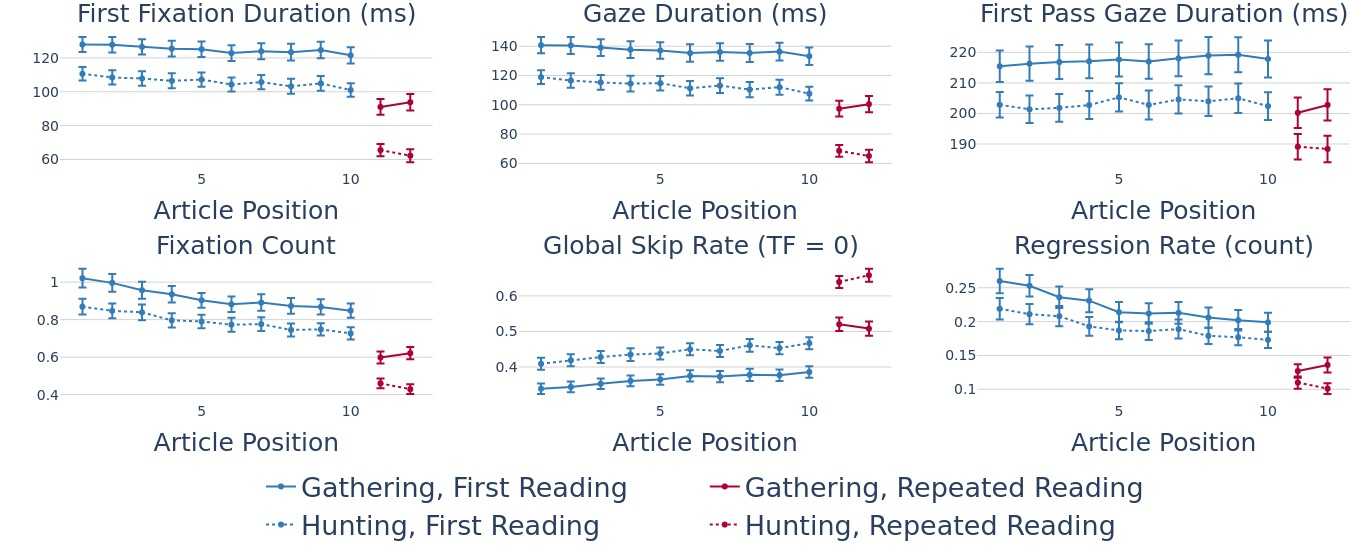

In [ ]:
fig = make_subplots(
    rows=2,
    cols=3,
    subplot_titles=tuple(
        [
            outcome_name_mapping[outcome]
            + (
                f" {outcome_units_mapping[outcome]}"
                if outcome not in ["IA_SKIP", "IA_RUN_COUNT"]
                else ""
            )
            for outcome in all_outcomes
        ]
    ),
    vertical_spacing=0.25,
)

FR_RR_colors = colors[4:6]
for i, outcome in enumerate(all_outcomes):
    means_outcome = means_all_outcomes.loc[lambda x: x["outcome_variable"] == outcome]
    hp_colors = colors[4:6]
    # In the plot add 2 traces for read and reread with different hue
    for j, hp_val in enumerate(["Gathering", "Hunting"]):
        means_outcome_hp = means_outcome.loc[lambda x: (x["has_preview"] == hp_val)]
        # print(means_outcome_hp)
        if len(means_outcome_hp) == 0:
            continue
        row = (i // 3) + 1
        col = (i % 3) + 1
        means_outcome_read = means_outcome_hp.loc[
            lambda x: x["article_ind"] <= 10
        ].sort_values(by="article_ind")
        means_outcome_reread = means_outcome_hp.loc[
            lambda x: x["article_ind"] > 10
        ].sort_values(by="article_ind")
        if len(means_outcome_read) > 0:
            fig.add_trace(
                go.Scatter(
                    x=means_outcome_read["article_ind"],
                    y=means_outcome_read["mean"],
                    error_y=dict(type="data", array=means_outcome_read["2se"]),
                    name=hp_val + ", " + "First Reading",
                    marker=dict(color=colors[0]),
                    showlegend=True if i == 0 else False,
                    line=dict(dash="solid" if j == 0 else "dot"),
                ),
                row=row,
                col=col,
            )
        if len(means_outcome_reread) > 0:
            fig.add_trace(
                go.Scatter(
                    x=means_outcome_reread["article_ind"].to_list(),
                    y=means_outcome_reread["mean"].to_list(),
                    error_y=dict(type="data", array=means_outcome_reread["2se"]),
                    name=hp_val + ", " + "Repeated Reading",
                    marker=dict(color=colors[1]),
                    showlegend=True if i == 0 else False,
                    line=dict(dash="solid" if j == 0 else "dot"),
                ),
                row=row,
                col=col,
            )

        fig.update_layout(
            plot_bgcolor="rgba(0,0,0,0)",
            # xaxis=dict(gridcolor="LightGray"),
            yaxis=dict(gridcolor="LightGray"),
        )

        fig.update_yaxes(
            title_text="",
            title_font=dict(size=25),
            tickfont=dict(size=14),
            row=row,
            col=col,
        )

        fig.update_xaxes(
            title_text="Article Position",
            title_font=dict(size=25),
            tickfont=dict(size=14),
            row=row,
            col=col,
        )

for i in range(9):
    # fig['layout']['xaxis' + str(i + 1)]['showgrid'] = True
    # fig['layout']['xaxis' + str(i + 1)]['gridcolor'] = 'lightgray'
    try:
        fig["layout"]["yaxis" + str(i + 1)]["showgrid"] = True # type: ignore
        fig["layout"]["yaxis" + str(i + 1)]["gridcolor"] = "lightgray" # type: ignore
    except Exception:
        continue
# increse all font by 10
fig.update_layout(
    height=550,
    width=1350,
)
fig.update_layout(font=dict(size=25))
fig.update_annotations(font_size=25)

# remove all margins
fig.update_layout(margin=dict(l=0, r=0, b=0, t=30))
# move the legend to the bottom
fig = fig.update_layout(
    legend=dict(
        yanchor="bottom",
        y=-0.4,
        xanchor="center",
        x=0.5,
        font=dict(size=27),
        orientation="h",
    )
)

fig.show(renderer="jpg")

In [20]:
upload(
    fig, "CogSci 2024 - Rereading", "sm_figures/means_by_article_ind_all_outcomes.pdf"
)

Test for a general decrease in reading times over the course of the experiment during first reading.

In [23]:
ling_featurse_formula = """
IA_DWELL_TIME ~ 1 + article_ind + (1 + article_ind | subject_id) + (1 + article_ind | unique_paragraph_id)
"""
_ = run_linear_mm(
    et_data_enriched.query("article_ind <= 10 and has_preview == 'Gathering'"),
    formula=ling_featurse_formula,
    re_cols=re_columns,
    outcome_variable="IA_DWELL_TIME",
)
_ = run_linear_mm(
    et_data_enriched.query("article_ind <= 10 and has_preview == 'Hunting'"),
    formula=ling_featurse_formula,
    re_cols=re_columns,
    outcome_variable="IA_DWELL_TIME",
)

ling_featurse_formula = """
IA_SKIP ~ 1 + article_ind + (1 + article_ind | subject_id) + (1 + article_ind | unique_paragraph_id)
"""
_ = run_linear_mm(
    et_data_enriched.query("article_ind <= 10 and has_preview == 'Gathering'"),
    formula=ling_featurse_formula,
    re_cols=re_columns,
    outcome_variable="IA_SKIP",
)
_ = run_linear_mm(
    et_data_enriched.query("article_ind <= 10 and has_preview == 'Hunting'"),
    formula=ling_featurse_formula,
    re_cols=re_columns,
    outcome_variable="IA_SKIP",
)

<PyCall.jlwrap Linear mixed model fit by maximum likelihood
 IA_DWELL_TIME ~ 1 + article_ind + (1 + article_ind | subject_id) + (1 + article_ind | unique_paragraph_id)
     logLik     -2 logLik        AIC           AICc          BIC      
 -5537853.9204 11075707.8408 11075725.8408 11075725.8410 11075830.2537

Variance components:
                       Column     Variance   Std.Dev.   Corr.
unique_paragraph_id (Intercept)   1140.45499  33.77062
                    article_ind     10.08913   3.17634 -0.59
subject_id          (Intercept)   5960.44126  77.20389
                    article_ind     27.11267   5.20698 -0.41
Residual                         52988.18742 230.19163
 Number of obs: 807285; levels of grouping factors: 324, 180

  Fixed-effects parameters:
───────────────────────────────────────────────────
                 Coef.  Std. Error      z  Pr(>|z|)
───────────────────────────────────────────────────
(Intercept)  216.192      6.08103   35.55    <1e-99
article_ind   -3.4049

remember {outcome} ~ 1 + article_ind + zerocorr(1 + article_ind | subject_id) + zerocorr(1 + article_ind | unique_paragraph_id) and looking at the p_val of 11vs.12 is equivilant to including only 11 vs. 12 in the data


In [9]:
for outcome in ["IA_DWELL_TIME", "IA_SKIP"] + all_outcomes:
    print("---------------------------------------------------------")
    print(outcome)
    print("---------------------------------------------------------")
    for hp_val in ["Hunting", "Gathering"]:
        print(f"{hp_val}: ")
        formula = f"{outcome} ~ 1 + article_ind + zerocorr(1 + article_ind | subject_id) + zerocorr(1 + article_ind | unique_paragraph_id)"

        coeff_table, _ = run_linear_mm(
            et_data_enriched.loc[lambda x: x["has_preview"] == hp_val],
            outcome,
            re_columns,
            formula,
            model_res_var_name="j_model",
            contrasts_dict={"article_ind": "SDC"},
            centralize_covariates=True,
            centralize_outcome=False,
            z_outcome=False,
            print_model_res=False,
        )
        print(
            coeff_table.loc[lambda x: x["Name"] == "article_ind: 12"][
                ["Coef.", "Pr(>|z|)"]
            ]
        )

---------------------------------------------------------
IA_DWELL_TIME
---------------------------------------------------------
Hunting: 


       Coef.  Pr(>|z|)
11 -6.068751  0.016107
Gathering: 
       Coef.  Pr(>|z|)
11  5.582773  0.038667
---------------------------------------------------------
IA_SKIP
---------------------------------------------------------
Hunting: 
       Coef.  Pr(>|z|)
11  0.015309  0.005582
Gathering: 
       Coef.  Pr(>|z|)
11 -0.005005  0.345056
---------------------------------------------------------
IA_FIRST_FIXATION_DURATION
---------------------------------------------------------
Hunting: 
       Coef.  Pr(>|z|)
11 -3.330142   0.01904
Gathering: 
       Coef.  Pr(>|z|)
11  2.776507  0.041845
---------------------------------------------------------
IA_FIRST_RUN_DWELL_TIME
---------------------------------------------------------
Hunting: 
       Coef.  Pr(>|z|)
11 -3.565587  0.018439
Gathering: 
       Coef.  Pr(>|z|)
11  3.088088  0.041507
---------------------------------------------------------
IA_FIRST_PASS_GAZE_DURATION
---------------------------------------------------------
Hun

/data/home/meiri.yoav/OneStopGaze-Preprocessing/reread_analysis/word_features_response_analyses/julia_linear_mm.py:175: UserWarning: The dataframe contains nans. Records with nans are omitted The following columns contain nans: Index(['IA_FIRST_PASS_GAZE_DURATION'], dtype='object')
  warnings.warn(


     Coef.  Pr(>|z|)
11 -0.1466  0.895022
Gathering: 


/data/home/meiri.yoav/OneStopGaze-Preprocessing/reread_analysis/word_features_response_analyses/julia_linear_mm.py:175: UserWarning: The dataframe contains nans. Records with nans are omitted The following columns contain nans: Index(['IA_FIRST_PASS_GAZE_DURATION'], dtype='object')
  warnings.warn(


      Coef.  Pr(>|z|)
11  2.53545  0.014641
---------------------------------------------------------
IA_RUN_COUNT
---------------------------------------------------------
Hunting: 
       Coef.  Pr(>|z|)
11 -0.031051  0.009799
Gathering: 
       Coef.  Pr(>|z|)
11  0.022507  0.041853
---------------------------------------------------------
IA_ZERO_TF
---------------------------------------------------------
Hunting: 
       Coef.  Pr(>|z|)
11  0.019015  0.009395
Gathering: 
       Coef.  Pr(>|z|)
11 -0.011848  0.040564
---------------------------------------------------------
IA_REGRESSION_OUT_FULL_COUNT
---------------------------------------------------------
Hunting: 
       Coef.  Pr(>|z|)
11 -0.010073  0.005446
Gathering: 
       Coef.  Pr(>|z|)
11  0.008551  0.013193


In [ ]:
for outcome in ["IA_DWELL_TIME", "IA_SKIP"] + all_outcomes:
    print("---------------------------------------------------------")
    print(outcome)
    print("---------------------------------------------------------")
    for hp_val in ["Hunting", "Gathering"]:
        print(f"{hp_val}: ")
        formula = f"{outcome} ~ 1 + article_ind + zerocorr(1 + article_ind | subject_id) + zerocorr(1 + article_ind | unique_paragraph_id)"

        coeff_table, _ = run_linear_mm(
            et_data_enriched.query(f"has_preview == '{hp_val}' and article_ind <= 10"),
            outcome,
            re_columns,
            formula,
            model_res_var_name="j_model",
            centralize_covariates=False,
            centralize_outcome=False,
            z_outcome=False,
            print_model_res=False,
        )
        print(
            coeff_table.loc[lambda x: x["Name"] == "article_ind"][["Coef.", "Pr(>|z|)"]]
        )

---------------------------------------------------------
IA_DWELL_TIME
---------------------------------------------------------
Hunting: 
      Coef.      Pr(>|z|)
1 -2.896752  9.010395e-14
Gathering: 
      Coef.      Pr(>|z|)
1 -3.386581  1.954232e-15
---------------------------------------------------------
IA_SKIP
---------------------------------------------------------
Hunting: 
      Coef.      Pr(>|z|)
1  0.003057  4.285589e-07
Gathering: 
     Coef.  Pr(>|z|)
1  0.00085  0.144306
---------------------------------------------------------
IA_FIRST_FIXATION_DURATION
---------------------------------------------------------
Hunting: 
      Coef.      Pr(>|z|)
1 -0.864002  6.019852e-08
Gathering: 
     Coef.      Pr(>|z|)
1 -0.63345  1.543769e-07
---------------------------------------------------------
IA_FIRST_RUN_DWELL_TIME
---------------------------------------------------------
Hunting: 
      Coef.      Pr(>|z|)
1 -1.031657  5.707520e-09
Gathering: 
      Coef.      Pr(>|z

## TFD, skip rate ~ reread & has_preview


In [6]:
# in et_data_enriched translate Hunting to 1 anf Gathering to 0

et_data_enriched["has_preview"] = et_data_enriched["has_preview"].map(
    {"Hunting": 1, "Gathering": 0}
)

In [7]:
means_all_outcomes = calc_mm_means_for_all_outcomes(
    et_data_enriched,
    ["reread", "has_preview"],
    re_columns,
    ["IA_DWELL_TIME", "IA_SKIP"],
    mean_mode="subset_mean",
)

outcome_variable: IA_DWELL_TIME
df_m shape before dropping nan: (1824643, 111)
df_m shape after dropping nan: (1824643, 111)
u_vals: ['0__0', '0__1', '1__0', '1__1']


100%|██████████| 4/4 [00:25<00:00,  6.39s/it]


outcome_variable: IA_SKIP
df_m shape before dropping nan: (1824643, 111)
df_m shape after dropping nan: (1824643, 111)
u_vals: ['0__0', '0__1', '1__0', '1__1']


100%|██████████| 4/4 [00:05<00:00,  1.26s/it]


In [8]:
means_all_outcomes

,mean,p_val,2se,outcome_variable,reread,has_preview
0,196.652,3.160360e-293,10.532,IA_DWELL_TIME,0,0
1,162.031,0.000000e+00,7.450,IA_DWELL_TIME,0,1
2,124.547,3.388478e-205,7.986,IA_DWELL_TIME,1,0
3,86.424,6.708100e-207,5.519,IA_DWELL_TIME,1,1
0,0.555,0.000000e+00,0.015,IA_SKIP,0,0
1,0.621,0.000000e+00,0.016,IA_SKIP,0,1
2,0.645,0.000000e+00,0.017,IA_SKIP,1,0
3,0.773,0.000000e+00,0.015,IA_SKIP,1,1


In [9]:
colors[0] = "#347BB9"
colors[1] = "#AE0135"

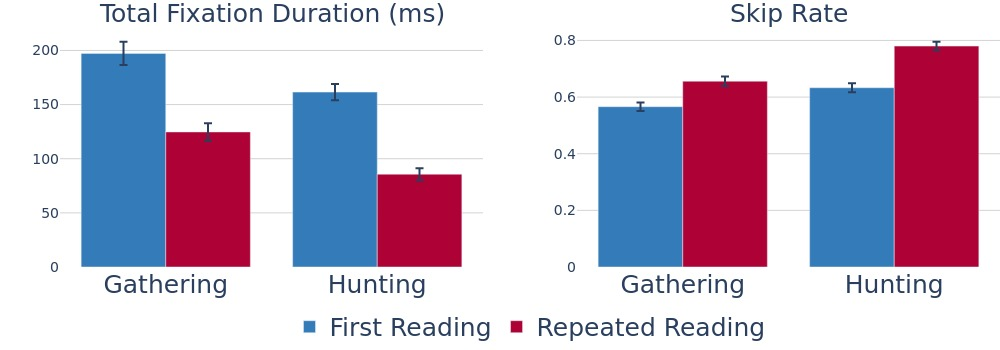

In [37]:
means_all_outcomes["reread"] = means_all_outcomes["reread"].apply(
    lambda x: "First Reading" if x == "0" else "Repeated Reading" if x == "1" else x
)
means_all_outcomes["has_preview"] = means_all_outcomes["has_preview"].apply(
    lambda x: "Gathering" if x == "0" else "Hunting" if x == "1" else x
)


fig = make_subplots(
    rows=1,
    cols=2,
    subplot_titles=["Total Fixation Duration (ms)", "Skip Rate"],
    vertical_spacing=0.1,
)

# create a subplot for each value of ['gpt2_Surprisal', 'Wordfreq_Frequency', 'Length']
# in each subplot create a primary x axis for the has_preview and a secondary x axis for the first_second_reading types
# Use Coef. for the bar values and Std. Error for the error bars

has_preview_vars = ["Hunting", "Gathering"]
hp_colors = colors[0:3]
reread_vars = ["First Reading", "Repeated Reading"]
fsrt_colors = colors[0:3]


for i, outcome_variable in enumerate(["IA_DWELL_TIME", "IA_SKIP"]):
    for j, rr_val in enumerate(reread_vars):
        hp_res = means_all_outcomes.loc[lambda x: x["reread"] == rr_val]
        fig.add_trace(
            go.Bar(
                x=hp_res.loc[lambda x: x["outcome_variable"] == outcome_variable][
                    "has_preview"
                ],
                y=hp_res.loc[lambda x: x["outcome_variable"] == outcome_variable][
                    "mean"
                ],
                error_y=dict(
                    type="data",
                    array=hp_res.loc[
                        lambda x: x["outcome_variable"] == outcome_variable
                    ]["2se"],
                ),
                name="First Reading" if j == 0 else "Repeated Reading",
                marker=dict(color=fsrt_colors[j]),
                showlegend=True if i == 0 else False,
            ),
            row=1,
            col=i + 1,
        )
    fig.update_layout(
        plot_bgcolor="rgba(0,0,0,0)",
        # xaxis=dict(gridcolor="LightGray"),
        yaxis=dict(gridcolor="LightGray"),
    )

    fig.update_yaxes(
        title_text="",
        title_font=dict(size=25),
        tickfont=dict(size=14),
        row=1,
        col=i + 1,
    )

fig.update_layout(
    height=350,
    width=1000,
)

# increse all font by 10
fig.update_layout(font=dict(size=25))
fig.update_annotations(font_size=25)

for i in range(2):
    # turn the grid background to white
    fig["layout"]["yaxis" + str(i + 1)]["showgrid"] = True # type: ignore
    fig["layout"]["yaxis" + str(i + 1)]["gridcolor"] = "lightgray" # type: ignore
# remove all margins
fig.update_layout(margin=dict(l=0, r=0, b=0, t=30))
# move the legend to the bottom
fig = fig.update_layout(
    legend=dict(
        yanchor="bottom",
        y=-0.35,
        xanchor="center",
        x=0.5,
        font=dict(size=25),
        orientation="h",
    )
)

fig.show(renderer="jpg")

In [38]:
upload(fig, "CogSci 2024 - Rereading", "main_figures/means_by_reread_and_preview.pdf")

In [42]:
et_data_enriched["has_preview"] = et_data_enriched["has_preview"].transform(
    lambda x: "Hunting" if x == 1 else "Gathering"
)

### Hunting test


In [53]:
for outcome in ["IA_DWELL_TIME", "IA_SKIP"] + all_outcomes:
    print("---------------------------------------------------------")
    print(outcome)
    print("---------------------------------------------------------")
    formula = f"{outcome} ~ 1 + reread + (1 + reread | subject_id) + (1 + reread | unique_paragraph_id)"
    coeff_table, _ = run_linear_mm(
        et_data_enriched.loc[lambda x: x["has_preview"] == "Hunting"],
        outcome,
        re_columns,
        formula,
        model_res_var_name="j_model",
        # centralize_covariates=True,
        centralize_outcome=False,
        z_outcome=False,
        print_model_res=False,
    )  # Se   for the entire fue
    # print the coefficient for the reread variable
    print(coeff_table.loc[lambda x: x["Name"] == "reread"][["Coef.", "Pr(>|z|)"]])

---------------------------------------------------------
IA_DWELL_TIME
---------------------------------------------------------
      Coef.       Pr(>|z|)
1 -75.75652  1.629073e-139
---------------------------------------------------------
IA_SKIP
---------------------------------------------------------
     Coef.       Pr(>|z|)
1  0.14729  4.738336e-116
---------------------------------------------------------
IA_FIRST_FIXATION_DURATION
---------------------------------------------------------
       Coef.       Pr(>|z|)
1 -42.175748  5.969577e-159
---------------------------------------------------------
IA_FIRST_RUN_DWELL_TIME
---------------------------------------------------------
       Coef.       Pr(>|z|)
1 -46.795791  1.029211e-155
---------------------------------------------------------
IA_FIRST_PASS_GAZE_DURATION
---------------------------------------------------------


/data/home/meiri.yoav/OneStopGaze-Preprocessing/reread_analysis/word_features_response_analyses/julia_linear_mm.py:175: UserWarning:

The dataframe contains nans. Records with nans are omitted The following columns contain nans: Index(['IA_FIRST_PASS_GAZE_DURATION'], dtype='object')



       Coef.      Pr(>|z|)
1 -14.625033  1.050702e-41
---------------------------------------------------------
IA_RUN_COUNT
---------------------------------------------------------
      Coef.       Pr(>|z|)
1 -0.347208  1.646284e-150
---------------------------------------------------------
IA_ZERO_TF
---------------------------------------------------------
      Coef.       Pr(>|z|)
1  0.208227  1.660168e-178
---------------------------------------------------------
IA_REGRESSION_OUT_FULL_COUNT
---------------------------------------------------------
      Coef.      Pr(>|z|)
1 -0.087319  4.848770e-89


### Gathering Test


In [54]:
for outcome in ["IA_DWELL_TIME", "IA_SKIP"] + all_outcomes:
    print("---------------------------------------------------------")
    print(outcome)
    print("---------------------------------------------------------")
    formula = f"{outcome} ~ 1 + reread + (1 + reread | subject_id) + (1 + reread | unique_paragraph_id)"
    coeff_table, _ = run_linear_mm(
        et_data_enriched.loc[lambda x: x["has_preview"] == "Gathering"],
        outcome,
        re_columns,
        formula,
        model_res_var_name="j_model",
        # centralize_covariates=True,
        centralize_outcome=False,
        z_outcome=False,
        print_model_res=False,
    )  # Se   for the entire fue
    # print the coefficient for the reread variable
    print(coeff_table.loc[lambda x: x["Name"] == "reread"][["Coef.", "Pr(>|z|)"]])

---------------------------------------------------------
IA_DWELL_TIME
---------------------------------------------------------
       Coef.      Pr(>|z|)
1 -72.513728  1.566036e-88
---------------------------------------------------------
IA_SKIP
---------------------------------------------------------
      Coef.      Pr(>|z|)
1  0.089405  7.097515e-60
---------------------------------------------------------
IA_FIRST_FIXATION_DURATION
---------------------------------------------------------
      Coef.      Pr(>|z|)
1 -32.55407  1.594368e-88
---------------------------------------------------------
IA_FIRST_RUN_DWELL_TIME
---------------------------------------------------------
      Coef.      Pr(>|z|)
1 -38.29809  3.910622e-94
---------------------------------------------------------
IA_FIRST_PASS_GAZE_DURATION
---------------------------------------------------------


/data/home/meiri.yoav/OneStopGaze-Preprocessing/reread_analysis/word_features_response_analyses/julia_linear_mm.py:175: UserWarning:

The dataframe contains nans. Records with nans are omitted The following columns contain nans: Index(['IA_FIRST_PASS_GAZE_DURATION'], dtype='object')



       Coef.      Pr(>|z|)
1 -15.411329  3.373446e-43
---------------------------------------------------------
IA_RUN_COUNT
---------------------------------------------------------
      Coef.      Pr(>|z|)
1 -0.308158  1.984674e-99
---------------------------------------------------------
IA_ZERO_TF
---------------------------------------------------------
      Coef.       Pr(>|z|)
1  0.149533  7.136482e-109
---------------------------------------------------------
IA_REGRESSION_OUT_FULL_COUNT
---------------------------------------------------------
      Coef.      Pr(>|z|)
1 -0.091632  1.039311e-83


### Interaction Test


In [13]:
for outcome in ["IA_DWELL_TIME", "IA_SKIP"] + all_outcomes:
    print("---------------------------------------------------------")
    print(outcome)
    print("---------------------------------------------------------")
    formula = f"{outcome} ~ 1 + has_preview * reread + (1 + reread | subject_id) + (1 + has_preview * reread | unique_paragraph_id)"
    coeff_table, _ = run_linear_mm(
        et_data_enriched.replace({"has_preview": {"Hunting": 1, "Gathering": 0}}),
        outcome,
        re_columns,
        formula,
        model_res_var_name="j_model",
        centralize_covariates=True,
        centralize_outcome=False,
        z_outcome=False,
        print_model_res=False,
    )  # Se   for the entire fue
    print("has_preview:")
    print(coeff_table.loc[lambda x: x["Name"] == "has_preview"][["Coef.", "Pr(>|z|)"]])
    print("reread:")
    print(coeff_table.loc[lambda x: x["Name"] == "reread"][["Coef.", "Pr(>|z|)"]])
    print("Interaction:")
    print(
        coeff_table.loc[lambda x: x["Name"] == "has_preview & reread"][
            ["Coef.", "Pr(>|z|)"]
        ]
    )

---------------------------------------------------------
IA_DWELL_TIME
---------------------------------------------------------


/tmp/ipykernel_1604193/1483974476.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  et_data_enriched.replace({"has_preview": {"Hunting": 1, "Gathering": 0}}),


has_preview:
       Coef.      Pr(>|z|)
1 -35.287394  1.760249e-09
reread:
       Coef.       Pr(>|z|)
2 -73.799932  4.770398e-210
Interaction:
     Coef.  Pr(>|z|)
3 -3.42145  0.462716
---------------------------------------------------------
IA_SKIP
---------------------------------------------------------


/tmp/ipykernel_1604193/1483974476.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  et_data_enriched.replace({"has_preview": {"Hunting": 1, "Gathering": 0}}),


has_preview:
      Coef.      Pr(>|z|)
1  0.076981  6.728583e-13
reread:
      Coef.       Pr(>|z|)
2  0.120653  1.141694e-164
Interaction:
      Coef.      Pr(>|z|)
3  0.061195  5.996840e-13
---------------------------------------------------------
IA_FIRST_FIXATION_DURATION
---------------------------------------------------------


/tmp/ipykernel_1604193/1483974476.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  et_data_enriched.replace({"has_preview": {"Hunting": 1, "Gathering": 0}}),


has_preview:
       Coef.      Pr(>|z|)
1 -19.911229  5.444891e-13
reread:
       Coef.       Pr(>|z|)
2 -37.072997  2.863833e-232
Interaction:
      Coef.  Pr(>|z|)
3 -9.686367  0.000013
---------------------------------------------------------
IA_FIRST_RUN_DWELL_TIME
---------------------------------------------------------


/tmp/ipykernel_1604193/1483974476.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  et_data_enriched.replace({"has_preview": {"Hunting": 1, "Gathering": 0}}),


has_preview:
       Coef.      Pr(>|z|)
1 -23.977541  7.741232e-13
reread:
       Coef.       Pr(>|z|)
2 -41.757562  5.473567e-236
Interaction:
      Coef.  Pr(>|z|)
3 -8.750802  0.000451
---------------------------------------------------------
IA_FIRST_PASS_GAZE_DURATION
---------------------------------------------------------


/tmp/ipykernel_1604193/1483974476.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  et_data_enriched.replace({"has_preview": {"Hunting": 1, "Gathering": 0}}),
/data/home/meiri.yoav/OneStopGaze-Preprocessing/reread_analysis/src/julia_linear_mm.py:175: UserWarning: The dataframe contains nans. Records with nans are omitted The following columns contain nans: Index(['IA_FIRST_PASS_GAZE_DURATION'], dtype='object')
  warnings.warn(


has_preview:
       Coef.  Pr(>|z|)
1 -13.247654  0.000086
reread:
       Coef.      Pr(>|z|)
2 -14.551641  9.344140e-78
Interaction:
      Coef.  Pr(>|z|)
3  0.785899  0.604907
---------------------------------------------------------
IA_RUN_COUNT
---------------------------------------------------------


/tmp/ipykernel_1604193/1483974476.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  et_data_enriched.replace({"has_preview": {"Hunting": 1, "Gathering": 0}}),


has_preview:
      Coef.      Pr(>|z|)
1 -0.127478  4.254689e-09
reread:
      Coef.       Pr(>|z|)
2 -0.328773  2.788593e-232
Interaction:
      Coef.  Pr(>|z|)
3 -0.039562   0.04333
---------------------------------------------------------
IA_ZERO_TF
---------------------------------------------------------


/tmp/ipykernel_1604193/1483974476.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  et_data_enriched.replace({"has_preview": {"Hunting": 1, "Gathering": 0}}),


has_preview:
      Coef.      Pr(>|z|)
1  0.081878  7.816717e-17
reread:
      Coef.       Pr(>|z|)
2  0.177182  3.121708e-270
Interaction:
     Coef.      Pr(>|z|)
3  0.05944  8.690701e-10
---------------------------------------------------------
IA_REGRESSION_OUT_FULL_COUNT
---------------------------------------------------------


/tmp/ipykernel_1604193/1483974476.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  et_data_enriched.replace({"has_preview": {"Hunting": 1, "Gathering": 0}}),


has_preview:
      Coef.  Pr(>|z|)
1 -0.030071  0.000335
reread:
     Coef.       Pr(>|z|)
2 -0.09325  1.251729e-177
Interaction:
      Coef.  Pr(>|z|)
3  0.004213  0.516309


### SM - Multiple outcomes


In [10]:
means_all_outcomes = calc_mm_means_for_all_outcomes(
    et_data_enriched,
    ["reread", "has_preview"],
    re_columns,
    all_outcomes,
    mean_mode="subset_mean",
)

outcome_variable: IA_FIRST_FIXATION_DURATION
df_m shape before dropping nan: (1822712, 112)
df_m shape after dropping nan: (1822712, 112)
u_vals: ['0__Gathering', '0__Hunting', '1__Gathering', '1__Hunting']


100%|██████████| 4/4 [00:25<00:00,  6.31s/it]


outcome_variable: IA_FIRST_RUN_DWELL_TIME
df_m shape before dropping nan: (1822712, 112)
df_m shape after dropping nan: (1822712, 112)
u_vals: ['0__Gathering', '0__Hunting', '1__Gathering', '1__Hunting']


100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


outcome_variable: IA_FIRST_PASS_GAZE_DURATION
df_m shape before dropping nan: (1822712, 112)
df_m shape after dropping nan: (710783, 112)
u_vals: ['0__Gathering', '0__Hunting', '1__Gathering', '1__Hunting']


100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


outcome_variable: IA_RUN_COUNT
df_m shape before dropping nan: (1822712, 112)
df_m shape after dropping nan: (1822712, 112)
u_vals: ['0__Gathering', '0__Hunting', '1__Gathering', '1__Hunting']


100%|██████████| 4/4 [00:04<00:00,  1.16s/it]


outcome_variable: IA_ZERO_TF
df_m shape before dropping nan: (1822712, 112)
df_m shape after dropping nan: (1822712, 112)
u_vals: ['0__Gathering', '0__Hunting', '1__Gathering', '1__Hunting']


100%|██████████| 4/4 [00:05<00:00,  1.36s/it]


outcome_variable: IA_REGRESSION_OUT_FULL_COUNT
df_m shape before dropping nan: (1822712, 112)
df_m shape after dropping nan: (1822712, 112)
u_vals: ['0__Gathering', '0__Hunting', '1__Gathering', '1__Hunting']


100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


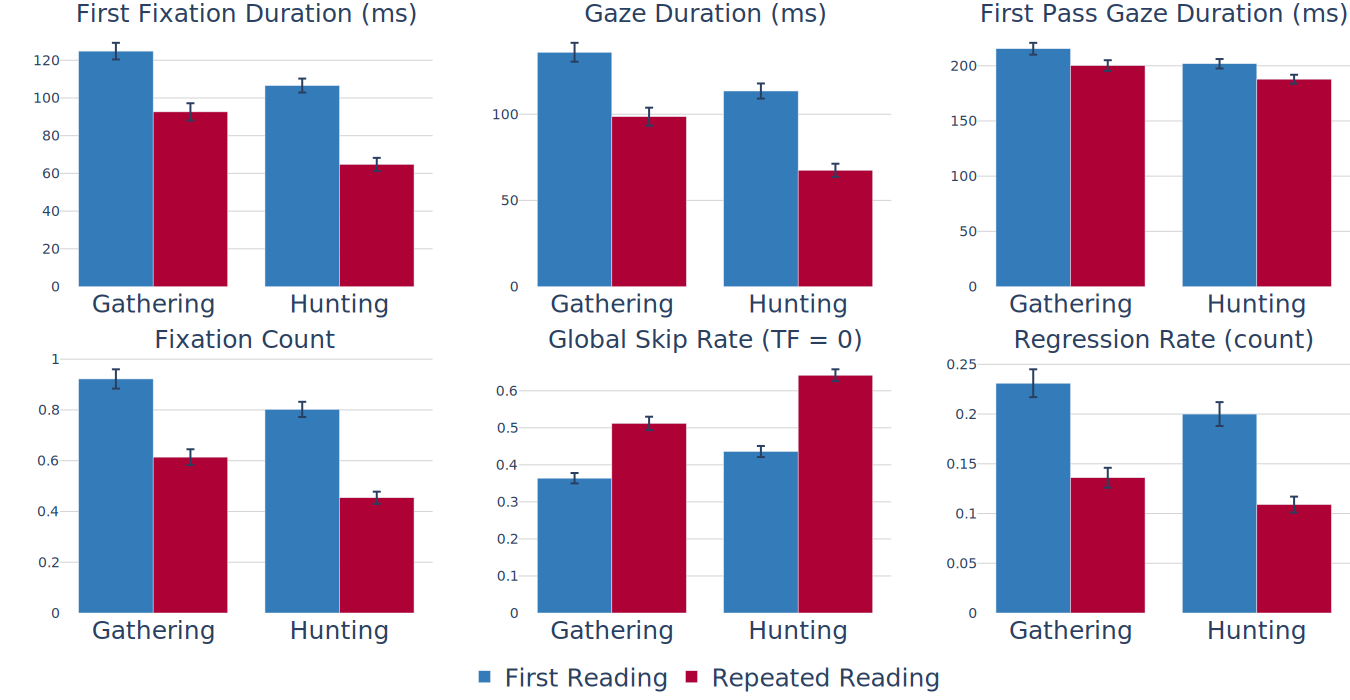

In [11]:
# in means_all_outcomes translate 0 to ordinary reading and 1 to rereading
means_all_outcomes["reread"] = means_all_outcomes["reread"].apply(
    lambda x: "First Reading" if x == "0" else "Repeated Reading" if x == "1" else x
)

fig = make_subplots(
    rows=2,
    cols=3,
    subplot_titles=tuple(
        [
            outcome_name_mapping[outcome]
            + (
                f" {outcome_units_mapping[outcome]}"
                if outcome not in ["IA_SKIP", "IA_RUN_COUNT"]
                else ""
            )
            for outcome in all_outcomes
        ]
    ),
    vertical_spacing=0.12,
)

FR_RR_colors = colors[4:6]
for i, outcome in enumerate(all_outcomes):
    row = (i // 3) + 1
    col = (i % 3) + 1
    means_outcome = means_all_outcomes.loc[lambda x: x["outcome_variable"] == outcome]
    hp_colors = colors[4:6]
    # In the plot add 2 traces for read and reread with different hue
    for j, rr_val in enumerate(["First Reading", "Repeated Reading"]):
        means_outcome_rr = means_outcome.loc[lambda x: (x["reread"] == rr_val)]
        fig.add_trace(
            go.Bar(
                x=means_outcome_rr["has_preview"],
                y=means_outcome_rr["mean"],
                error_y=dict(type="data", array=means_outcome_rr["2se"]),
                name=rr_val,
                marker=dict(color=colors[j]),
                showlegend=True if i == 0 else False,
            ),
            row=row,
            col=col,
        )

    fig.update_layout(
        plot_bgcolor="rgba(0,0,0,0)",
        # xaxis=dict(gridcolor="LightGray"),
        yaxis=dict(gridcolor="LightGray"),
    )

    fig.update_yaxes(
        title_text="",
        title_font=dict(size=25),
        tickfont=dict(size=14),
        row=row,
        col=col,
    )

for i in range(9):
    # fig['layout']['xaxis' + str(i + 1)]['showgrid'] = True
    # fig['layout']['xaxis' + str(i + 1)]['gridcolor'] = 'lightgray'
    try:
        fig["layout"]["yaxis" + str(i + 1)]["showgrid"] = True # type: ignore
        fig["layout"]["yaxis" + str(i + 1)]["gridcolor"] = "lightgray" # type: ignore
    except:  # noqa: E722
        continue
# increse all font by 10
fig.update_layout(
    height=350 * 2,
    width=1350,
)
fig.update_layout(font=dict(size=25))
fig.update_annotations(font_size=25)

# remove all margins
fig.update_layout(margin=dict(l=0, r=0, b=0, t=30))
# move the legend to the bottom
fig = fig.update_layout(
    legend=dict(
        yanchor="bottom",
        y=-0.15,
        xanchor="center",
        x=0.5,
        font=dict(size=25),
        orientation="h",
    )
)

fig.show(renderer="svg")

In [13]:
upload(
    fig,
    "CogSci 2024 - Rereading",
    "sm_figures/means_by_reread_and_preview_all_outcomes.pdf",
)

## TFD ~ relative_to_aspan & reread - Only Hunting


In [ ]:
et_data_enriched["reread_and_same_CS"] = et_data_enriched.apply(
    lambda x: (
        "First_Reading"
        if x["reread"] == 0
        else "RR_same_CS"
        if x["reread"] == 1 and x["same_span_in_FR"]
        else "RR_diff_CS"
    ),
    axis=1,
)
et_data_enriched["reread_and_same_CS"].value_counts()

reread_and_same_CS
First_Reading    1521055
RR_same_CS        187803
RR_diff_CS        115785
Name: count, dtype: int64

### Split to same cs in rr and diff cs in rr


In [6]:
et_data_enriched.query("has_preview == 'Hunting'")["same_span_in_FR"].value_counts()

same_span_in_FR
.        761445
False    115785
True      36245
Name: count, dtype: int64

In [7]:
et_data_enriched.query("has_preview == 'Hunting'")["is_in_aspan"].value_counts()

is_in_aspan
False    639942
True     273533
Name: count, dtype: int64

In [8]:
means_all_outcomes = calc_mm_means_for_all_outcomes(
    et_data_enriched.query("has_preview == 'Hunting'"),
    ["is_in_aspan", "reread_and_same_CS"],
    re_columns,
    ["IA_DWELL_TIME", "IA_SKIP"],
    mean_mode="subset_mean",
)

outcome_variable: IA_DWELL_TIME
df_m shape before dropping nan: (913475, 111)
df_m shape after dropping nan: (913475, 111)
u_vals: ['False__First_Reading', 'False__RR_diff_CS', 'False__RR_same_CS', 'True__First_Reading', 'True__RR_diff_CS', 'True__RR_same_CS']


100%|██████████| 6/6 [00:25<00:00,  4.17s/it]


outcome_variable: IA_SKIP
df_m shape before dropping nan: (913475, 111)
df_m shape after dropping nan: (913475, 111)
u_vals: ['False__First_Reading', 'False__RR_diff_CS', 'False__RR_same_CS', 'True__First_Reading', 'True__RR_diff_CS', 'True__RR_same_CS']


100%|██████████| 6/6 [00:04<00:00,  1.50it/s]


In [9]:
means_all_outcomes["is_in_aspan"] = means_all_outcomes["is_in_aspan"].apply(
    lambda x: "Outside CS" if x == "False" else "Inside CS"
)
# in reread_and_same_CS, translate First_Reading to First Reading, RR_diff_CS to Repeated Reading - Same CS between First and Repeated Reading, RR_same_CS to Repeated Reading - Different CS between First and Repeated Reading
means_all_outcomes["reread_and_same_CS"] = means_all_outcomes[
    "reread_and_same_CS"
].apply(
    lambda x: (
        "First Reading"
        if x == "First_Reading"
        else (
            "Repeated Reading - Same CS between First and Repeated Reading"
            if x == "RR_same_CS"
            else "Repeated Reading - Different CS between First and Repeated Reading"
        )
    )
)

means_all_outcomes

,mean,p_val,2se,outcome_variable,is_in_aspan,reread_and_same_CS
0,148.085,0.000000e+00,7.474,IA_DWELL_TIME,Outside CS,First Reading
1,69.655,6.121645e-129,5.651,IA_DWELL_TIME,Outside CS,Repeated Reading - Different CS between First ...
2,64.717,1.976963e-38,9.785,IA_DWELL_TIME,Outside CS,Repeated Reading - Same CS between First and R...
3,194.307,0.000000e+00,9.141,IA_DWELL_TIME,Inside CS,First Reading
4,131.362,1.573133e-179,9.012,IA_DWELL_TIME,Inside CS,Repeated Reading - Different CS between First ...
5,113.974,6.956359e-98,10.639,IA_DWELL_TIME,Inside CS,Repeated Reading - Same CS between First and R...
0,0.628,0.000000e+00,0.017,IA_SKIP,Outside CS,First Reading
1,0.788,0.000000e+00,0.016,IA_SKIP,Outside CS,Repeated Reading - Different CS between First ...
2,0.806,0.000000e+00,0.023,IA_SKIP,Outside CS,Repeated Reading - Same CS between First and R...
3,0.607,0.000000e+00,0.015,IA_SKIP,Inside CS,First Reading


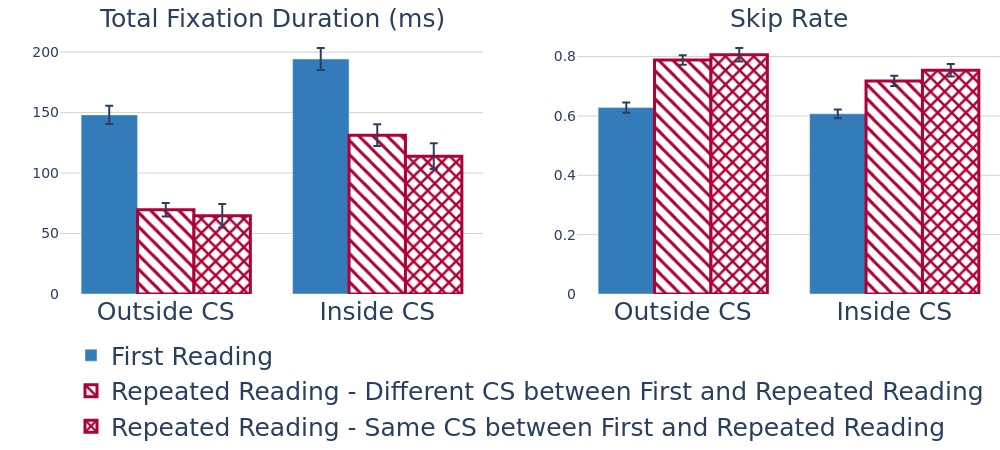

In [10]:
fig = make_subplots(
    rows=1,
    cols=2,
    subplot_titles=["Total Fixation Duration (ms)", "Skip Rate"],
)

has_preview_vars = ["Hunting", "Gathering"]
hp_colors = colors[0:3]
reread_vars = [
    "First Reading",
    "Repeated Reading - Different CS between First and Repeated Reading",
    "Repeated Reading - Same CS between First and Repeated Reading",
]
fsrt_colors = [colors[0], colors[1], colors[1]]


for i, outcome_variable in enumerate(["IA_DWELL_TIME", "IA_SKIP"]):
    for j, rr_val in enumerate(reread_vars):
        hp_res = means_all_outcomes.loc[lambda x: x["reread_and_same_CS"] == rr_val]
        fig.add_trace(
            go.Bar(
                x=hp_res.loc[lambda x: x["outcome_variable"] == outcome_variable][
                    "is_in_aspan"
                ],
                y=hp_res.loc[lambda x: x["outcome_variable"] == outcome_variable][
                    "mean"
                ],
                error_y=dict(
                    type="data",
                    array=hp_res.loc[
                        lambda x: x["outcome_variable"] == outcome_variable
                    ]["2se"],
                ),
                name=rr_val,
                marker=dict(color=fsrt_colors[j]),
                marker_line=dict(width=3, color=colors[1]) if j >= 1 else None,
                showlegend=True if i == 0 else False,
                # if j == 2 assign pattern to the bar
                marker_pattern=dict(
                    shape="x",
                    fgcolor=colors[1],
                    bgcolor="white",
                    fgopacity=1,
                    solidity=0.45,
                )
                if j == 2
                else dict(
                    shape="\\",
                    fgcolor=colors[1],
                    bgcolor="white",
                    fgopacity=1,
                    solidity=0.3,
                )
                if j == 1
                else None,  # ['', '/', '\\', 'x', '-', '|', '+', '.']
            ),
            row=1,
            col=i + 1,
        )
    fig.update_layout(
        plot_bgcolor="rgba(0,0,0,0)",
        # xaxis=dict(gridcolor="LightGray"),
        yaxis=dict(gridcolor="LightGray"),
    )

    fig.update_yaxes(
        title_text="",
        title_font=dict(size=25),
        tickfont=dict(size=14),
        row=1,
        col=i + 1,
    )
fig.update_layout(margin=dict(l=0, r=0, b=0, t=50))
fig.update_layout(
    height=450,
    width=1000,
)

# increse all font by 10
fig.update_layout(font=dict(size=25))
fig.update_annotations(font_size=25)

for i in range(2):
    # turn the grid background to white
    fig["layout"]["yaxis" + str(i + 1)]["showgrid"] = True # type: ignore
    fig["layout"]["yaxis" + str(i + 1)]["gridcolor"] = "lightgray" # type: ignore
# remove all margins

# move the legend to the bottom
fig = fig.update_layout(
    legend=dict(
        yanchor="bottom",
        y=-0.6,
        xanchor="center",
        x=0.5,
        font=dict(size=25),
        orientation="h",
    )
)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=35))
fig.show(renderer="jpg")

In [11]:
upload(
    fig,
    "CogSci 2024 - Rereading",
    "main_figures/hunting_means_by_reread_relative_to_span.pdf",
)

### SM - All outcomes

In [12]:
means_all_outcomes = calc_mm_means_for_all_outcomes(
    et_data_enriched.query("has_preview == 'Hunting'"),
    ["is_in_aspan", "reread_and_same_CS"],
    re_columns,
    all_outcomes,
    mean_mode="subset_mean",
)

outcome_variable: IA_FIRST_FIXATION_DURATION
df_m shape before dropping nan: (913475, 112)
df_m shape after dropping nan: (913475, 112)
u_vals: ['False__First_Reading', 'False__RR_diff_CS', 'False__RR_same_CS', 'True__First_Reading', 'True__RR_diff_CS', 'True__RR_same_CS']


100%|██████████| 6/6 [00:04<00:00,  1.40it/s]


outcome_variable: IA_FIRST_RUN_DWELL_TIME
df_m shape before dropping nan: (913475, 112)
df_m shape after dropping nan: (913475, 112)
u_vals: ['False__First_Reading', 'False__RR_diff_CS', 'False__RR_same_CS', 'True__First_Reading', 'True__RR_diff_CS', 'True__RR_same_CS']


100%|██████████| 6/6 [00:04<00:00,  1.36it/s]


outcome_variable: IA_FIRST_PASS_GAZE_DURATION
df_m shape before dropping nan: (913475, 112)
df_m shape after dropping nan: (320551, 112)
u_vals: ['False__First_Reading', 'False__RR_diff_CS', 'False__RR_same_CS', 'True__First_Reading', 'True__RR_diff_CS', 'True__RR_same_CS']


100%|██████████| 6/6 [00:05<00:00,  1.11it/s]


outcome_variable: IA_RUN_COUNT
df_m shape before dropping nan: (913475, 112)
df_m shape after dropping nan: (913475, 112)
u_vals: ['False__First_Reading', 'False__RR_diff_CS', 'False__RR_same_CS', 'True__First_Reading', 'True__RR_diff_CS', 'True__RR_same_CS']


100%|██████████| 6/6 [00:04<00:00,  1.35it/s]


outcome_variable: IA_ZERO_TF
df_m shape before dropping nan: (913475, 112)
df_m shape after dropping nan: (913475, 112)
u_vals: ['False__First_Reading', 'False__RR_diff_CS', 'False__RR_same_CS', 'True__First_Reading', 'True__RR_diff_CS', 'True__RR_same_CS']


100%|██████████| 6/6 [00:05<00:00,  1.15it/s]


outcome_variable: IA_REGRESSION_OUT_FULL_COUNT
df_m shape before dropping nan: (913475, 112)
df_m shape after dropping nan: (913475, 112)
u_vals: ['False__First_Reading', 'False__RR_diff_CS', 'False__RR_same_CS', 'True__First_Reading', 'True__RR_diff_CS', 'True__RR_same_CS']


100%|██████████| 6/6 [00:04<00:00,  1.36it/s]


In [13]:
means_all_outcomes["is_in_aspan"] = means_all_outcomes["is_in_aspan"].apply(
    lambda x: "Outside CS" if x == "False" else "Inside CS"
)
# in reread_and_same_CS, translate First_Reading to First Reading, RR_diff_CS to Repeated Reading - Same CS between First and Repeated Reading, RR_same_CS to Repeated Reading - Different CS between First and Repeated Reading
means_all_outcomes["reread_and_same_CS"] = means_all_outcomes[
    "reread_and_same_CS"
].apply(
    lambda x: (
        "First Reading"
        if x == "First_Reading"
        else (
            "Repeated Reading - Same CS between First and Repeated Reading"
            if x == "RR_same_CS"
            else "Repeated Reading - Different CS between First and Repeated Reading"
        )
    )
)

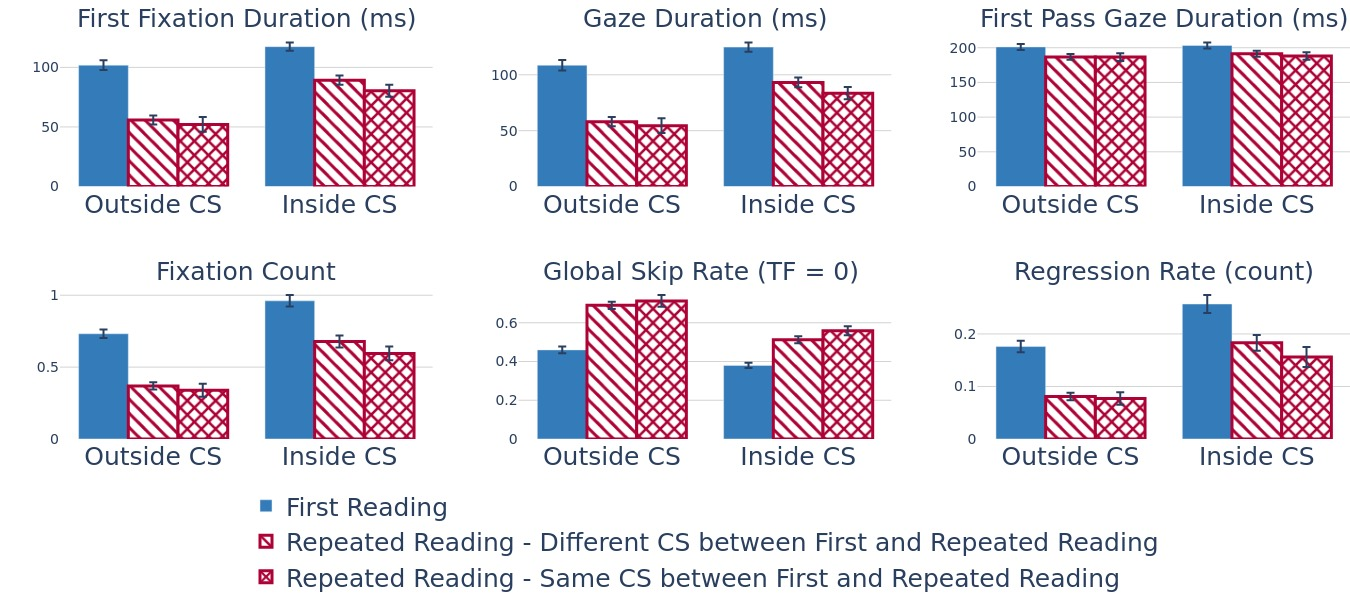

In [14]:
fig = make_subplots(
    rows=2,
    cols=3,
    subplot_titles=tuple(
        [
            outcome_name_mapping[outcome]
            + (
                f" {outcome_units_mapping[outcome]}"
                if outcome not in ["IA_SKIP", "IA_RUN_COUNT"]
                else ""
            )
            for outcome in all_outcomes
        ]
    ),
)

# create a subplot for each value of ['gpt2_Surprisal', 'Wordfreq_Frequency', 'Length']
# in each subplot create a primary x axis for the has_preview and a secondary x axis for the first_second_reading types
# Use Coef. for the bar values and Std. Error for the error bars

has_preview_vars = ["Hunting", "Gathering"]
hp_colors = colors[0:3]
reread_vars = [
    "First Reading",
    "Repeated Reading - Different CS between First and Repeated Reading",
    "Repeated Reading - Same CS between First and Repeated Reading",
]
fsrt_colors = [colors[0], colors[1], colors[1]]


for i, outcome_variable in enumerate(all_outcomes):
    row = (i // 3) + 1
    col = (i % 3) + 1
    for j, rr_val in enumerate(reread_vars):
        hp_res = means_all_outcomes.loc[lambda x: x["reread_and_same_CS"] == rr_val]
        fig.add_trace(
            go.Bar(
                x=hp_res.loc[lambda x: x["outcome_variable"] == outcome_variable][
                    "is_in_aspan"
                ],
                y=hp_res.loc[lambda x: x["outcome_variable"] == outcome_variable][
                    "mean"
                ],
                error_y=dict(
                    type="data",
                    array=hp_res.loc[
                        lambda x: x["outcome_variable"] == outcome_variable
                    ]["2se"],
                ),
                name=rr_val,
                marker=dict(color=fsrt_colors[j]),
                marker_line=dict(width=3, color=colors[1]) if j >= 1 else None,
                showlegend=True if i == 0 else False,
                # if j == 2 assign pattern to the bar
                marker_pattern=dict(
                    shape="x",
                    fgcolor=colors[1],
                    bgcolor="white",
                    fgopacity=1,
                    solidity=0.45,
                )
                if j == 2
                else dict(
                    shape="\\",
                    fgcolor=colors[1],
                    bgcolor="white",
                    fgopacity=1,
                    solidity=0.3,
                )
                if j == 1
                else None,  # ['', '/', '\\', 'x', '-', '|', '+', '.']
            ),
            row=row,
            col=col,
        )
    fig.update_layout(
        plot_bgcolor="rgba(0,0,0,0)",
        # xaxis=dict(gridcolor="LightGray"),
        yaxis=dict(gridcolor="LightGray"),
    )

    fig.update_yaxes(
        title_text="",
        title_font=dict(size=25),
        tickfont=dict(size=14),
        row=row,
        col=col,
    )
fig.update_layout(margin=dict(l=0, r=0, b=0, t=50))
fig.update_layout(
    height=600,
    width=1350,
)

# increse all font by 10
fig.update_layout(font=dict(size=25))
fig.update_annotations(font_size=25)

for i in range(6):
    # turn the grid background to white
    fig["layout"]["yaxis" + str(i + 1)]["showgrid"] = True # type: ignore
    fig["layout"]["yaxis" + str(i + 1)]["gridcolor"] = "lightgray" # type: ignore
# remove all margins

# move the legend to the bottom
fig = fig.update_layout(
    legend=dict(
        yanchor="bottom",
        y=-0.4,
        xanchor="center",
        x=0.5,
        font=dict(size=25),
        orientation="h",
    )
)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=35))
fig.show(renderer="jpg")

In [15]:
upload(
    fig,
    "CogSci 2024 - Rereading",
    "sm_figures/means_by_reread_relative_to_span_all_outcomes.pdf",
)

### SM - All outcomes - No Hunting / Gathering distinction

In [16]:
means_all_outcomes = calc_mm_means_for_all_outcomes(
    et_data_enriched.query("has_preview == 'Hunting'"),
    ["reread_and_same_CS"],
    re_columns,
    all_outcomes,
    mean_mode="subset_mean",
)

outcome_variable: IA_FIRST_FIXATION_DURATION
df_m shape before dropping nan: (913475, 112)
df_m shape after dropping nan: (913475, 112)
u_vals: ['First_Reading', 'RR_diff_CS', 'RR_same_CS']


100%|██████████| 3/3 [00:03<00:00,  1.02s/it]


outcome_variable: IA_FIRST_RUN_DWELL_TIME
df_m shape before dropping nan: (913475, 112)
df_m shape after dropping nan: (913475, 112)
u_vals: ['First_Reading', 'RR_diff_CS', 'RR_same_CS']


100%|██████████| 3/3 [00:02<00:00,  1.10it/s]


outcome_variable: IA_FIRST_PASS_GAZE_DURATION
df_m shape before dropping nan: (913475, 112)
df_m shape after dropping nan: (320551, 112)
u_vals: ['First_Reading', 'RR_diff_CS', 'RR_same_CS']


100%|██████████| 3/3 [00:01<00:00,  1.74it/s]


outcome_variable: IA_RUN_COUNT
df_m shape before dropping nan: (913475, 112)
df_m shape after dropping nan: (913475, 112)
u_vals: ['First_Reading', 'RR_diff_CS', 'RR_same_CS']


100%|██████████| 3/3 [00:02<00:00,  1.04it/s]


outcome_variable: IA_ZERO_TF
df_m shape before dropping nan: (913475, 112)
df_m shape after dropping nan: (913475, 112)
u_vals: ['First_Reading', 'RR_diff_CS', 'RR_same_CS']


100%|██████████| 3/3 [00:03<00:00,  1.03s/it]


outcome_variable: IA_REGRESSION_OUT_FULL_COUNT
df_m shape before dropping nan: (913475, 112)
df_m shape after dropping nan: (913475, 112)
u_vals: ['First_Reading', 'RR_diff_CS', 'RR_same_CS']


100%|██████████| 3/3 [00:02<00:00,  1.13it/s]


In [17]:
# in reread_and_same_CS, translate First_Reading to First Reading, RR_diff_CS to Repeated Reading - Same CS between First and Repeated Reading, RR_same_CS to Repeated Reading - Different CS between First and Repeated Reading
means_all_outcomes["reread_and_same_CS"] = means_all_outcomes[
    "reread_and_same_CS"
].apply(
    lambda x: "First Reading"
    if x == "First_Reading"
    else "Repeated Reading - Same CS between First and Repeated Reading"
    if x == "RR_same_CS"
    else "Repeated Reading - Different CS between First and Repeated Reading"
)

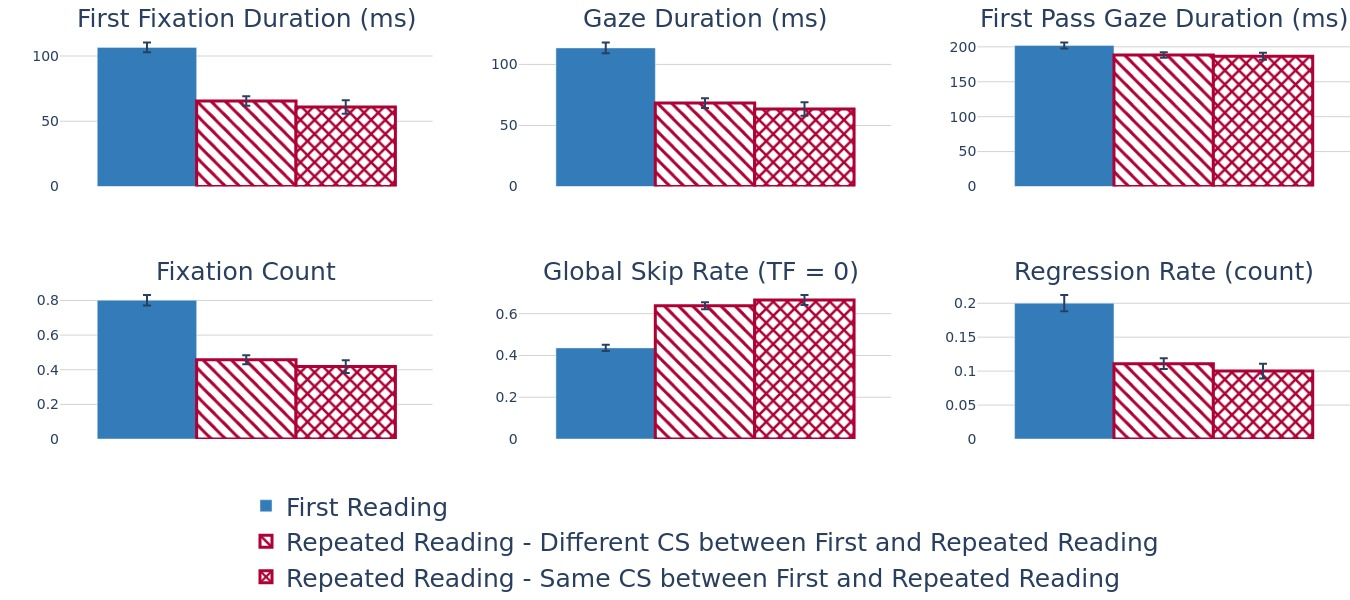

In [18]:
fig = make_subplots(
    rows=2,
    cols=3,
    subplot_titles=tuple(
        [
            outcome_name_mapping[outcome]
            + (
                f" {outcome_units_mapping[outcome]}"
                if outcome not in ["IA_SKIP", "IA_RUN_COUNT"]
                else ""
            )
            for outcome in all_outcomes
        ]
    ),
)

has_preview_vars = ["Hunting", "Gathering"]
hp_colors = colors[0:3]
reread_vars = [
    "First Reading",
    "Repeated Reading - Different CS between First and Repeated Reading",
    "Repeated Reading - Same CS between First and Repeated Reading",
]
fsrt_colors = [colors[0], colors[1], colors[1]]


for i, outcome_variable in enumerate(all_outcomes):
    row = (i // 3) + 1
    col = (i % 3) + 1
    for j, rr_val in enumerate(reread_vars):
        hp_res = means_all_outcomes.loc[lambda x: x["reread_and_same_CS"] == rr_val]
        fig.add_trace(
            go.Bar(
                y=hp_res.loc[lambda x: x["outcome_variable"] == outcome_variable][
                    "mean"
                ],
                error_y=dict(
                    type="data",
                    array=hp_res.loc[
                        lambda x: x["outcome_variable"] == outcome_variable
                    ]["2se"],
                ),
                name=rr_val,
                marker=dict(color=fsrt_colors[j]),
                marker_line=dict(width=3, color=colors[1]) if j >= 1 else None,
                showlegend=True if i == 0 else False,
                # if j == 2 assign pattern to the bar
                marker_pattern=dict(
                    shape="x",
                    fgcolor=colors[1],
                    bgcolor="white",
                    fgopacity=1,
                    solidity=0.45,
                )
                if j == 2
                else dict(
                    shape="\\",
                    fgcolor=colors[1],
                    bgcolor="white",
                    fgopacity=1,
                    solidity=0.3,
                )
                if j == 1
                else None,
            ),
            row=row,
            col=col,
        )
    fig.update_layout(
        plot_bgcolor="rgba(0,0,0,0)",
        # xaxis=dict(gridcolor="LightGray"),
        yaxis=dict(gridcolor="LightGray"),
    )

    # set the x axis title to ling_feature
    fig.update_xaxes(
        title_text="",
        # set the ticks to None
        tickmode="array",
        tickvals=[],
        row=row,
        col=col,
    )
    fig.update_yaxes(
        title_text="",
        title_font=dict(size=25),
        tickfont=dict(size=14),
        row=row,
        col=col,
    )
fig.update_layout(margin=dict(l=0, r=0, b=0, t=50))
fig.update_layout(
    height=600,
    width=1350,
)

# increse all font by 10
fig.update_layout(font=dict(size=25))
fig.update_annotations(font_size=25)

for i in range(6):
    # turn the grid background to white
    fig["layout"]["yaxis" + str(i + 1)]["showgrid"] = True # type: ignore
    fig["layout"]["yaxis" + str(i + 1)]["gridcolor"] = "lightgray" # type: ignore
# remove all margins

# move the legend to the bottom
fig = fig.update_layout(
    legend=dict(
        yanchor="bottom",
        y=-0.4,
        xanchor="center",
        x=0.5,
        font=dict(size=25),
        orientation="h",
    )
)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=35))
fig.show(renderer="jpg")

In [19]:
upload(
    fig,
    "CogSci 2024 - Rereading",
    "sm_figures/means_by_reread_diff_CS.pdf",
)

### Main Tests

First, we observe a reading facilitation both inside and
outside the critical span, with a larger facilitation outside the critical span


In [45]:
for outcome in ["IA_DWELL_TIME", "IA_SKIP"] + all_outcomes:
    print("---------------------------------------------------------")
    print(outcome)
    print("---------------------------------------------------------")
    for inside in [True, False]:
        print("Inside CS" if inside else "Outside CS")
        coeff_table = run_linear_mm(
            et_data_enriched.query(
                f"has_preview == 'Hunting' and is_in_aspan == {inside}"
            ),
            outcome,
            re_columns,
            f"{outcome} ~ 1 + reread + (1 + reread | subject_id) + (1 + reread | unique_paragraph_id)",
            model_res_var_name="j_model",
            # centralize_covariates=True,
            centralize_outcome=False,
            z_outcome=False,
            print_model_res=False,
        )[0]
        print(coeff_table.loc[lambda x: x["Name"] == "reread"][["Coef.", "Pr(>|z|)"]])

---------------------------------------------------------
IA_DWELL_TIME
---------------------------------------------------------
Inside CS


       Coef.      Pr(>|z|)
1 -66.490541  8.489618e-73
Outside CS
       Coef.       Pr(>|z|)
1 -79.083635  1.129241e-140
---------------------------------------------------------
IA_SKIP
---------------------------------------------------------
Inside CS
      Coef.      Pr(>|z|)
1  0.116724  1.872535e-74
Outside CS
      Coef.       Pr(>|z|)
1  0.160809  2.830353e-119
---------------------------------------------------------
IA_FIRST_FIXATION_DURATION
---------------------------------------------------------
Inside CS
       Coef.      Pr(>|z|)
1 -30.366621  2.723727e-87
Outside CS
       Coef.       Pr(>|z|)
1 -47.072344  3.009613e-160
---------------------------------------------------------
IA_FIRST_RUN_DWELL_TIME
---------------------------------------------------------
Inside CS
       Coef.      Pr(>|z|)
1 -34.466744  9.821540e-92
Outside CS
       Coef.       Pr(>|z|)
1 -51.880553  3.422130e-155
---------------------------------------------------------
IA_FIRST_PASS_GAZE_DURATI

/data/home/meiri.yoav/OneStopGaze-Preprocessing/reread_analysis/word_features_response_analyses/julia_linear_mm.py:175: UserWarning:

The dataframe contains nans. Records with nans are omitted The following columns contain nans: Index(['IA_FIRST_PASS_GAZE_DURATION'], dtype='object')



      Coef.      Pr(>|z|)
1 -13.24131  4.211977e-27
Outside CS


/data/home/meiri.yoav/OneStopGaze-Preprocessing/reread_analysis/word_features_response_analyses/julia_linear_mm.py:175: UserWarning:

The dataframe contains nans. Records with nans are omitted The following columns contain nans: Index(['IA_FIRST_PASS_GAZE_DURATION'], dtype='object')



       Coef.      Pr(>|z|)
1 -15.492223  4.296682e-41
---------------------------------------------------------
IA_RUN_COUNT
---------------------------------------------------------
Inside CS
     Coef.      Pr(>|z|)
1 -0.29832  7.189089e-71
Outside CS
      Coef.       Pr(>|z|)
1 -0.365796  3.802628e-153
---------------------------------------------------------
IA_ZERO_TF
---------------------------------------------------------
Inside CS
      Coef.      Pr(>|z|)
1  0.143846  1.215339e-92
Outside CS
      Coef.       Pr(>|z|)
1  0.235326  1.943554e-175
---------------------------------------------------------
IA_REGRESSION_OUT_FULL_COUNT
---------------------------------------------------------
Inside CS
      Coef.      Pr(>|z|)
1 -0.076626  2.039911e-39
Outside CS
      Coef.      Pr(>|z|)
1 -0.091597  4.297224e-93


With a larger effect outside the critical span - Interaction term repeated : span in RT ∼ repeated ∗ span +
(repeated + span|sub j) + (repeated + span|parag).


In [46]:
for outcome in ["IA_DWELL_TIME", "IA_SKIP"] + all_outcomes:
    print("---------------------------------------------------------")
    print(outcome)
    print("---------------------------------------------------------")
    coeff_table = run_linear_mm(
        et_data_enriched.query("has_preview == 'Hunting'"),
        outcome,
        re_columns,
        f"{outcome} ~ 1 + reread * is_in_aspan + (1 + reread * is_in_aspan | subject_id) + (1 + reread * is_in_aspan | unique_paragraph_id)",
        model_res_var_name="j_model",
        # centralize_covariates=True,
        centralize_outcome=False,
        z_outcome=False,
        print_model_res=False,
    )[0]
    print(
        coeff_table.loc[lambda x: x["Name"] == "reread & is_in_aspan"][
            ["Coef.", "Pr(>|z|)"]
        ]
    )

---------------------------------------------------------
IA_DWELL_TIME
---------------------------------------------------------


      Coef.  Pr(>|z|)
3  12.65528  0.000019
---------------------------------------------------------
IA_SKIP
---------------------------------------------------------
     Coef.      Pr(>|z|)
3 -0.04414  2.215528e-20
---------------------------------------------------------
IA_FIRST_FIXATION_DURATION
---------------------------------------------------------
       Coef.      Pr(>|z|)
3  16.668373  8.181697e-35
---------------------------------------------------------
IA_FIRST_RUN_DWELL_TIME
---------------------------------------------------------
       Coef.      Pr(>|z|)
3  17.373233  5.019060e-33
---------------------------------------------------------
IA_FIRST_PASS_GAZE_DURATION
---------------------------------------------------------


/data/home/meiri.yoav/OneStopGaze-Preprocessing/reread_analysis/word_features_response_analyses/julia_linear_mm.py:175: UserWarning:

The dataframe contains nans. Records with nans are omitted The following columns contain nans: Index(['IA_FIRST_PASS_GAZE_DURATION'], dtype='object')



      Coef.  Pr(>|z|)
3  2.297854  0.048715
---------------------------------------------------------
IA_RUN_COUNT
---------------------------------------------------------
      Coef.  Pr(>|z|)
3  0.067956  0.000002
---------------------------------------------------------
IA_ZERO_TF
---------------------------------------------------------
      Coef.      Pr(>|z|)
3 -0.091398  2.479301e-38
---------------------------------------------------------
IA_REGRESSION_OUT_FULL_COUNT
---------------------------------------------------------
      Coef.  Pr(>|z|)
3  0.015099  0.002343


We further note that SR changes in repeated reading are larger when the first and the repeated readings share the same critical span ($p=0.02$).
A qualitatively similar difference appears in TF, albeit bot significantly


same_cs term in RT ∼ same_cs + (same_cs|sub j) +
(same_cs|parag) in repeated reading only


In [21]:
df_copy = et_data_enriched.copy()
df_copy = df_copy.query("has_preview == 'Hunting' and reread == 1")
# in reread_and_same_CS turn RR_same_CS to 1 and RR_diff_CS to 0 and rename the column to same_span_in_FR
df_copy["same_span_in_FR"] = df_copy["reread_and_same_CS"].apply(
    lambda x: 1 if x == "RR_same_CS" else 0
)

for outcome in ["IA_DWELL_TIME", "IA_SKIP"] + all_outcomes:
    print("---------------------------------------------------------")
    print(outcome)
    print("---------------------------------------------------------")
    coeff_table = run_linear_mm(
        df_copy,
        outcome,
        re_columns,
        f"{outcome} ~ 1 + same_span_in_FR + (1 + same_span_in_FR | subject_id) + (1 + same_span_in_FR | unique_paragraph_id)",
        model_res_var_name="j_model",
        # centralize_covariates=True,
        centralize_outcome=False,
        z_outcome=False,
        print_model_res=False,
    )[0]
    print(
        coeff_table.loc[lambda x: x["Name"] == "same_span_in_FR"][["Coef.", "Pr(>|z|)"]]
    )

---------------------------------------------------------
IA_DWELL_TIME
---------------------------------------------------------
      Coef.  Pr(>|z|)
1 -7.393207  0.045646
---------------------------------------------------------
IA_SKIP
---------------------------------------------------------
      Coef.  Pr(>|z|)
1  0.019889  0.012874
---------------------------------------------------------
IA_FIRST_FIXATION_DURATION
---------------------------------------------------------
      Coef.  Pr(>|z|)
1 -4.545434  0.028936
---------------------------------------------------------
IA_FIRST_RUN_DWELL_TIME
---------------------------------------------------------
      Coef.  Pr(>|z|)
1 -4.720407   0.03225
---------------------------------------------------------
IA_FIRST_PASS_GAZE_DURATION
---------------------------------------------------------


/data/home/meiri.yoav/OneStopGaze-Preprocessing/reread_analysis/src/julia_linear_mm.py:175: UserWarning:

The dataframe contains nans. Records with nans are omitted The following columns contain nans: Index(['IA_FIRST_PASS_GAZE_DURATION'], dtype='object')



      Coef.  Pr(>|z|)
1 -1.366401   0.32677
---------------------------------------------------------
IA_RUN_COUNT
---------------------------------------------------------
      Coef.  Pr(>|z|)
1 -0.039182  0.028055
---------------------------------------------------------
IA_ZERO_TF
---------------------------------------------------------
      Coef.  Pr(>|z|)
1  0.026078  0.014916
---------------------------------------------------------
IA_REGRESSION_OUT_FULL_COUNT
---------------------------------------------------------
     Coef.  Pr(>|z|)
1 -0.01058  0.048174


this overall difference is driven by lower repeated reading times within the critical span , while differences outside the critical span are not significant


In [20]:
df_copy = et_data_enriched.copy()
df_copy = df_copy.query("has_preview == 'Hunting' and reread == 1")
# in reread_and_same_CS turn RR_same_CS to 1 and RR_diff_CS to 0 and rename the column to same_span_in_FR
df_copy["same_span_in_FR"] = df_copy["reread_and_same_CS"].apply(
    lambda x: 1 if x == "RR_same_CS" else 0
)

for outcome in ["IA_DWELL_TIME", "IA_SKIP"] + all_outcomes:
    print("-----------------------------------------------")
    print(outcome)
    print("-----------------------------------------------")
    for outside in [True, False]:
        print("Outside CS" if outside else "Inside CS")
        if outside:
            df_copy_outside = df_copy.query("is_in_aspan == False")
        else:
            df_copy_outside = df_copy.query("is_in_aspan == True")
        coeff_table = run_linear_mm(
            df_copy_outside,
            outcome,
            re_columns,
            f"{outcome} ~ 1 + same_span_in_FR + (1 + same_span_in_FR | subject_id) + (1 + same_span_in_FR | unique_paragraph_id)",
            model_res_var_name="j_model",
            # centralize_covariates=True,
            centralize_outcome=False,
            z_outcome=False,
            print_model_res=False,
        )[0]
        print(
            coeff_table.loc[lambda x: x["Name"] == "same_span_in_FR"][
                ["Coef.", "Pr(>|z|)"]
            ]
        )

-----------------------------------------------
IA_DWELL_TIME
-----------------------------------------------
Outside CS
      Coef.  Pr(>|z|)
1 -4.519877  0.296444
Inside CS
       Coef.  Pr(>|z|)
1 -16.549087  0.002416
-----------------------------------------------
IA_SKIP
-----------------------------------------------
Outside CS
      Coef.  Pr(>|z|)
1  0.016639  0.063336
Inside CS
      Coef.  Pr(>|z|)
1  0.034649  0.000238
-----------------------------------------------
IA_FIRST_FIXATION_DURATION
-----------------------------------------------
Outside CS
      Coef.  Pr(>|z|)
1 -3.664774    0.1552
Inside CS
      Coef.  Pr(>|z|)
1 -8.369426    0.0003
-----------------------------------------------
IA_FIRST_RUN_DWELL_TIME
-----------------------------------------------
Outside CS
      Coef.  Pr(>|z|)
1 -3.667609   0.17213
Inside CS
      Coef.  Pr(>|z|)
1 -9.092608  0.000312
-----------------------------------------------
IA_FIRST_PASS_GAZE_DURATION
-----------------------------

/data/home/meiri.yoav/OneStopGaze-Preprocessing/reread_analysis/src/julia_linear_mm.py:175: UserWarning:

The dataframe contains nans. Records with nans are omitted The following columns contain nans: Index(['IA_FIRST_PASS_GAZE_DURATION'], dtype='object')



      Coef.  Pr(>|z|)
1 -1.097798  0.526186
Inside CS


/data/home/meiri.yoav/OneStopGaze-Preprocessing/reread_analysis/src/julia_linear_mm.py:175: UserWarning:

The dataframe contains nans. Records with nans are omitted The following columns contain nans: Index(['IA_FIRST_PASS_GAZE_DURATION'], dtype='object')



      Coef.  Pr(>|z|)
1 -3.159226  0.126022
-----------------------------------------------
IA_RUN_COUNT
-----------------------------------------------
Outside CS
      Coef.  Pr(>|z|)
1 -0.027777  0.190187
Inside CS
      Coef.  Pr(>|z|)
1 -0.079191  0.001687
-----------------------------------------------
IA_ZERO_TF
-----------------------------------------------
Outside CS
      Coef.  Pr(>|z|)
1  0.022868  0.085214
Inside CS
      Coef.  Pr(>|z|)
1  0.043739  0.000148
-----------------------------------------------
IA_REGRESSION_OUT_FULL_COUNT
-----------------------------------------------
Outside CS
      Coef.  Pr(>|z|)
1 -0.004137  0.477808
Inside CS
      Coef.  Pr(>|z|)
1 -0.027323  0.001937


The interaction of same critical span – inside the critical span is significant in TF, Regression Rate and number of fixations (p < 0.03 for all three

In [22]:
df_copy = et_data_enriched.copy()
df_copy = df_copy.query("has_preview == 'Hunting' and reread == 1")
# in reread_and_same_CS turn RR_same_CS to 1 and RR_diff_CS to 0 and rename the column to same_span_in_FR
df_copy["same_span_in_FR"] = df_copy["reread_and_same_CS"].apply(
    lambda x: 1 if x == "RR_same_CS" else 0
)

for outcome in ["IA_DWELL_TIME", "IA_SKIP"] + all_outcomes:
    print("---------------------------------------------------------")
    print(outcome)
    print("---------------------------------------------------------")
    coeff_table = run_linear_mm(
        df_copy,
        outcome,
        re_columns,
        f"{outcome} ~ 1 + same_span_in_FR * is_in_aspan + (1 + same_span_in_FR * is_in_aspan | subject_id) + (1 + same_span_in_FR * is_in_aspan | unique_paragraph_id)",
        model_res_var_name="j_model",
        # centralize_covariates=True,
        centralize_outcome=False,
        z_outcome=False,
        print_model_res=False,
    )[0]
    print(
        coeff_table.loc[lambda x: x["Name"] == "same_span_in_FR & is_in_aspan"][
            ["Coef.", "Pr(>|z|)"]
        ]
    )

---------------------------------------------------------
IA_DWELL_TIME
---------------------------------------------------------
      Coef.  Pr(>|z|)
3 -11.83675  0.039317
---------------------------------------------------------
IA_SKIP
---------------------------------------------------------
      Coef.  Pr(>|z|)
3  0.018779  0.043748
---------------------------------------------------------
IA_FIRST_FIXATION_DURATION
---------------------------------------------------------
      Coef.  Pr(>|z|)
3 -4.895156   0.07035
---------------------------------------------------------
IA_FIRST_RUN_DWELL_TIME
---------------------------------------------------------
      Coef.  Pr(>|z|)
3 -5.492604  0.053958
---------------------------------------------------------
IA_FIRST_PASS_GAZE_DURATION
---------------------------------------------------------


/data/home/meiri.yoav/OneStopGaze-Preprocessing/reread_analysis/src/julia_linear_mm.py:175: UserWarning:

The dataframe contains nans. Records with nans are omitted The following columns contain nans: Index(['IA_FIRST_PASS_GAZE_DURATION'], dtype='object')



      Coef.  Pr(>|z|)
3 -2.055182  0.396604
---------------------------------------------------------
IA_RUN_COUNT
---------------------------------------------------------
      Coef.  Pr(>|z|)
3 -0.051823  0.059253
---------------------------------------------------------
IA_ZERO_TF
---------------------------------------------------------
      Coef.  Pr(>|z|)
3  0.021879  0.119879
---------------------------------------------------------
IA_REGRESSION_OUT_FULL_COUNT
---------------------------------------------------------
      Coef.  Pr(>|z|)
3 -0.022394  0.020319


### Other tests

Does the repeated:inside interaction hold when you consider only the same CS data?


In [ ]:
#  Does the repeated:inside interaction hold when you consider only the same CS data?
sub_df = et_data_enriched.query(
    "has_preview == 'Hunting' and reread_and_same_CS != 'RR_diff_CS'"
)
print(sub_df["reread_and_same_CS"].unique())
print(sub_df["is_in_aspan"].unique())
# in the reread_and_same_CS column, encode First_Reading as 0, RR_same_CS as 1
sub_df["reread_and_same_CS"] = sub_df["reread_and_same_CS"].apply(
    lambda x: 0 if x == "First_Reading" else 1
)
sub_df["relative_to_aspan"] = sub_df["relative_to_aspan"].apply(
    lambda x: 0 if x == "Before Critical Span" else 1
)


for outcome in ["IA_DWELL_TIME", "IA_SKIP"]:
    print("--------------------")
    print(outcome)
    _, _ = run_linear_mm(
        sub_df,
        outcome,
        re_columns,
        f"{outcome} ~ 1 + reread_and_same_CS * relative_to_aspan + (1 + reread_and_same_CS + relative_to_aspan | subject_id) + (1 + reread_and_same_CS + relative_to_aspan | unique_paragraph_id)",
        model_res_var_name="j_model",
        # centralize_covariates=True,
        centralize_outcome=False,
        z_outcome=False,
        print_model_res=True,
    )

['First_Reading' 'RR_same_CS']
[False  True]
--------------------
IA_DWELL_TIME
<PyCall.jlwrap Linear mixed model fit by maximum likelihood
 IA_DWELL_TIME ~ 1 + reread_and_same_CS + relative_to_aspan + reread_and_same_CS & relative_to_aspan + (1 + reread_and_same_CS + relative_to_aspan | subject_id) + (1 + reread_and_same_CS + relative_to_aspan | unique_paragraph_id)
     logLik     -2 logLik        AIC           AICc          BIC      
 -6022041.5930 12044083.1860 12044117.1860 12044117.1867 12044316.1045

Variance components:
                          Column        Variance  Std.Dev.   Corr.
unique_paragraph_id (Intercept)          1037.8841  32.2162
                    reread_and_same_CS    879.2440  29.6520 -0.20
                    relative_to_aspan     937.0413  30.6111 -0.70 -0.10
subject_id          (Intercept)          2843.0265  53.3200
                    reread_and_same_CS   1487.7273  38.5711 -0.60
                    relative_to_aspan     490.3416  22.1437 -0.31 -0.13
Res

Does the repeated:inside interaction hold when you consider only the diff CS data?


In [ ]:
#  Does the repeated:inside interaction hold when you consider only the diff CS data?
sub_df = et_data_enriched.query(
    "has_preview == 'Hunting' and reread_and_same_CS != 'RR_same_CS'"
)
print(sub_df["reread_and_same_CS"].unique())
print(sub_df["is_in_aspan"].unique())
# in the reread_and_same_CS column, encode First_Reading as 0, RR_same_CS as 1
sub_df["reread_and_same_CS"] = sub_df["reread_and_same_CS"].apply(
    lambda x: 0 if x == "First_Reading" else 1
)
sub_df["relative_to_aspan"] = sub_df["relative_to_aspan"].apply(
    lambda x: 0 if x == "Before Critical Span" else 1
)


for outcome in ["IA_DWELL_TIME", "IA_SKIP"]:
    print("--------------------")
    print(outcome)
    _, _ = run_linear_mm(
        sub_df,
        outcome,
        re_columns,
        f"{outcome} ~ 1 + reread_and_same_CS * relative_to_aspan + (1 + reread_and_same_CS + relative_to_aspan | subject_id) + (1 + reread_and_same_CS + relative_to_aspan | unique_paragraph_id)",
        model_res_var_name="j_model",
        # centralize_covariates=True,
        centralize_outcome=False,
        z_outcome=False,
        print_model_res=True,
    )

['First_Reading' 'RR_diff_CS']
[False  True]
--------------------
IA_DWELL_TIME
<PyCall.jlwrap Linear mixed model fit by maximum likelihood
 IA_DWELL_TIME ~ 1 + reread_and_same_CS + relative_to_aspan + reread_and_same_CS & relative_to_aspan + (1 + reread_and_same_CS + relative_to_aspan | subject_id) + (1 + reread_and_same_CS + relative_to_aspan | unique_paragraph_id)
     logLik     -2 logLik        AIC           AICc          BIC      
 -6688228.0117 13376456.0233 13376490.0233 13376490.0239 13376690.7860

Variance components:
                          Column        Variance  Std.Dev.   Corr.
unique_paragraph_id (Intercept)           974.4067  31.2155
                    reread_and_same_CS    620.9942  24.9198 -0.52
                    relative_to_aspan     816.1100  28.5676 -0.68 +0.15
subject_id          (Intercept)          2810.0730  53.0101
                    reread_and_same_CS   1373.8061  37.0649 -0.70
                    relative_to_aspan     465.3017  21.5709 -0.29 -0.10
Res

In [65]:
for outcome in ["IA_DWELL_TIME", "IA_SKIP"]:
    print("------------------------------------------------------------")
    print(outcome)
    print("Inside + ouside span - same CS vs. diff CS::::::::::::")
    """
    Here we take only RR (article_ind>10) because the facilitation in same/diff CS is outcome 
    value difference with respect to the same value (the outcome in the first reading) so
    we just compare them directly
    """
    coeff_table = run_linear_mm(
        et_data_enriched.query("has_preview == 'Hunting' and article_ind > 10"),
        outcome,
        re_columns,
        f"{outcome} ~ 1 + reread_and_same_CS + (1 + reread_and_same_CS | subject_id) + (1 + reread_and_same_CS | unique_paragraph_id)",
        model_res_var_name="j_model",
        # centralize_covariates=True,
        centralize_outcome=False,
        z_outcome=False,
        print_model_res=False,
    )[0]  # Se   for the entire fue
    # print the p value of reread_and_same_CS
    print(
        coeff_table.loc[
            lambda x: x["Name"] == "reread_and_same_CS: PyObject 'RR_same_CS'"
        ][["Coef.", "Pr(>|z|)"]]
    )

    print("Inside span - same CS vs. diff CS::::::::::::")
    coeff_table = run_linear_mm(
        et_data_enriched.query(
            "has_preview == 'Hunting' and article_ind > 10 and is_in_aspan == 1"
        ),
        outcome,
        re_columns,
        f"{outcome} ~ 1 + reread_and_same_CS + (1 + reread_and_same_CS | subject_id) + (1 + reread_and_same_CS | unique_paragraph_id)",
        model_res_var_name="j_model",
        # centralize_covariates=True,
        centralize_outcome=False,
        z_outcome=False,
        print_model_res=False,
    )[0]  # Se   for the entire fue
    # print the p value of reread_and_same_CS
    print(
        coeff_table.loc[
            lambda x: x["Name"] == "reread_and_same_CS: PyObject 'RR_same_CS'"
        ][["Coef.", "Pr(>|z|)"]]
    )

    print("Outside span - same CS vs. diff CS::::::::::::")
    coeff_table = run_linear_mm(
        et_data_enriched.query(
            "has_preview == 'Hunting' and article_ind > 10 and is_in_aspan == 0"
        ),
        outcome,
        re_columns,
        f"{outcome}~ 1 + reread_and_same_CS + (1 + reread_and_same_CS | subject_id) + (1 + reread_and_same_CS | unique_paragraph_id)",
        model_res_var_name="j_model",
        # centralize_covariates=True,
        centralize_outcome=False,
        z_outcome=False,
        print_model_res=False,
    )[0]  # Se   for the entire fue
    print(
        coeff_table.loc[
            lambda x: x["Name"] == "reread_and_same_CS: PyObject 'RR_same_CS'"
        ][["Coef.", "Pr(>|z|)"]]
    )

    print("Interaction::::::::::::")
    coeff_table = run_linear_mm(
        et_data_enriched.query("has_preview == 'Hunting' and article_ind > 10"),
        outcome,
        re_columns,
        f"{outcome} ~ 1 + reread_and_same_CS * is_in_aspan + (1 + reread_and_same_CS * is_in_aspan | subject_id) + (1 + reread_and_same_CS * is_in_aspan | unique_paragraph_id)",
        model_res_var_name="j_model",
        # centralize_covariates=True,
        centralize_outcome=False,
        z_outcome=False,
        print_model_res=False,
    )[0]  # Se   for the entire fue
    print(
        coeff_table.loc[
            lambda x: x["Name"]
            == "reread_and_same_CS: PyObject 'RR_same_CS' & is_in_aspan"
        ][["Coef.", "Pr(>|z|)"]]
    )

------------------------------------------------------------
IA_DWELL_TIME
Inside + ouside span - same CS vs. diff CS::::::::::::


      Coef.  Pr(>|z|)
1 -7.646485  0.036604
Inside span - same CS vs. diff CS::::::::::::
       Coef.  Pr(>|z|)
1 -17.057757  0.001309
Outside span - same CS vs. diff CS::::::::::::
      Coef.  Pr(>|z|)
1 -4.653516  0.283396
Interaction::::::::::::
       Coef.  Pr(>|z|)
3 -12.222962  0.029919
------------------------------------------------------------
IA_SKIP
Inside + ouside span - same CS vs. diff CS::::::::::::
      Coef.  Pr(>|z|)
1  0.019925  0.010852
Inside span - same CS vs. diff CS::::::::::::
      Coef.  Pr(>|z|)
1  0.034056  0.000181
Outside span - same CS vs. diff CS::::::::::::
      Coef.  Pr(>|z|)
1  0.016705   0.05589
Interaction::::::::::::
      Coef.  Pr(>|z|)
3  0.017836  0.045261


### SM - Inside / Outside CS, only Hunting or only Gathering


In [ ]:

run_linear_mm(
    et_data_enriched.query("has_preview == 'Hunting'"),
    "IA_SKIP",
    re_columns,
    "IA_SKIP ~ 1 + reread + (1 + reread | subject_id) + (1 + reread | unique_paragraph_id)",
    model_res_var_name="j_model",
    # centralize_covariates=True,
    centralize_outcome=False,
    z_outcome=False,
    print_model_res=True,
)

In [10]:
H_G = "Hunting"
# outcomes = all_outcomes
outcomes = ["IA_DWELL_TIME", "IA_SKIP"]
means_all_outcomes = calc_mm_means_for_all_outcomes(
    et_data_enriched.query(f"has_preview == '{H_G}'"),
    ["is_in_aspan", "reread"],
    re_columns,
    ["IA_DWELL_TIME", "IA_SKIP"],
    mean_mode="subset_mean",
)
means_all_outcomes["is_in_aspan"] = means_all_outcomes["is_in_aspan"].apply(
    lambda x: "Outside CS" if x == "False" else "Inside CS"
)

outcome_variable: IA_DWELL_TIME
df_m shape before dropping nan: (913475, 110)
df_m shape after dropping nan: (913475, 110)
u_vals: ['False__0', 'False__1', 'True__0', 'True__1']


100%|██████████| 4/4 [00:02<00:00,  1.72it/s]


outcome_variable: IA_SKIP
df_m shape before dropping nan: (913475, 110)
df_m shape after dropping nan: (913475, 110)
u_vals: ['False__0', 'False__1', 'True__0', 'True__1']


100%|██████████| 4/4 [00:02<00:00,  1.38it/s]


In [16]:
for outcome in outcomes:
    run_linear_mm(
        et_data_enriched.query("has_preview == 'Hunting'"),
        outcome,
        re_columns,
        f"{outcome} ~ 1 + reread * is_in_aspan + (1 + reread * is_in_aspan | subject_id) + (1 + reread * is_in_aspan | unique_paragraph_id)",
        model_res_var_name="j_model",
        # centralize_covariates=True,
        centralize_outcome=False,
        z_outcome=False,
        print_model_res=True,
    )

<PyCall.jlwrap Linear mixed model fit by maximum likelihood
 IA_DWELL_TIME ~ 1 + reread + is_in_aspan + reread & is_in_aspan + (1 + reread + is_in_aspan + reread & is_in_aspan | subject_id) + (1 + reread + is_in_aspan + reread & is_in_aspan | unique_paragraph_id)
     logLik     -2 logLik        AIC           AICc          BIC      
 -6119971.9316 12239943.8631 12239993.8631 12239993.8646 12240286.9884

Variance components:
                           Column         Variance  Std.Dev.   Corr.
unique_paragraph_id (Intercept)             601.4411  24.5243
                    reread                  468.5314  21.6456 -0.60
                    is_in_aspan            1288.1606  35.8910 -0.34 +0.22
                    reread & is_in_aspan   1066.0433  32.6503 +0.04 -0.23 -0.31
subject_id          (Intercept)            2265.0233  47.5923
                    reread                 1429.6324  37.8105 -0.74
                    is_in_aspan            1134.7689  33.6863 -0.08 +0.03
               

In [11]:
# convert the 0 and 1 of reread to First Reading and Repeated Reading
means_all_outcomes["reread"] = means_all_outcomes["reread"].apply(
    lambda x: "First Reading" if x == "0" else "Repeated Reading" if x == "1" else x
)

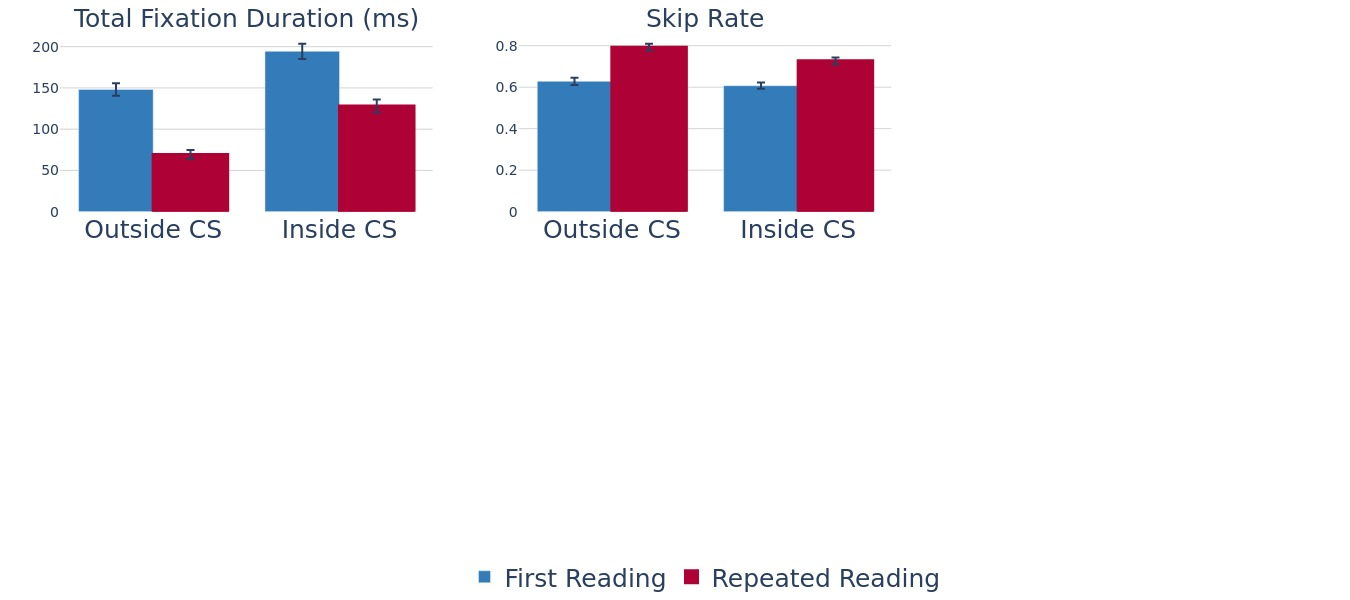

In [14]:
fig = make_subplots(
    rows=2,
    cols=3,
    subplot_titles=tuple(
        [
            outcome_name_mapping[outcome]
            + (
                f" {outcome_units_mapping[outcome]}"
                if outcome not in ["IA_SKIP", "IA_RUN_COUNT"]
                else ""
            )
            for outcome in outcomes
        ]
    ),
)
has_preview_vars = ["Hunting", "Gathering"]
hp_colors = colors[0:3]
reread_vars = [
    "First Reading",
    "Repeated Reading - Different CS between First and Repeated Reading",
    "Repeated Reading - Same CS between First and Repeated Reading",
]
fsrt_colors = [colors[0], colors[1], colors[1]]


for i, outcome_variable in enumerate(outcomes):
    row = (i // 3) + 1
    col = (i % 3) + 1
    for j, rr_val in enumerate(["First Reading", "Repeated Reading"]):
        hp_res = means_all_outcomes.loc[lambda x: x["reread"] == rr_val]
        fig.add_trace(
            go.Bar(
                x=hp_res.loc[lambda x: x["outcome_variable"] == outcome_variable][
                    "is_in_aspan"
                ],
                y=hp_res.loc[lambda x: x["outcome_variable"] == outcome_variable][
                    "mean"
                ],
                error_y=dict(
                    type="data",
                    array=hp_res.loc[
                        lambda x: x["outcome_variable"] == outcome_variable
                    ]["2se"],
                ),
                name=rr_val,
                marker=dict(color=fsrt_colors[j]),
                marker_line=dict(width=3, color=colors[1]) if j >= 1 else None,
                showlegend=True if i == 0 else False,
            ),
            row=row,
            col=col,
        )
    fig.update_layout(
        plot_bgcolor="rgba(0,0,0,0)",
        # xaxis=dict(gridcolor="LightGray"),
        yaxis=dict(gridcolor="LightGray"),
    )

    fig.update_yaxes(
        title_text="",
        title_font=dict(size=25),
        tickfont=dict(size=14),
        row=row,
        col=col,
    )
fig.update_layout(margin=dict(l=0, r=0, b=0, t=50))
fig.update_layout(
    height=600,
    width=1350,
)

# increse all font by 10
fig.update_layout(font=dict(size=25))
fig.update_annotations(font_size=25)

for i in range(6):
    # turn the grid background to white
    fig["layout"]["yaxis" + str(i + 1)]["showgrid"] = True  # type: ignore
    fig["layout"]["yaxis" + str(i + 1)]["gridcolor"] = "lightgray"  # type: ignore
# remove all margins

# move the legend to the bottom
fig = fig.update_layout(
    legend=dict(
        yanchor="bottom",
        y=-0.2,
        xanchor="center",
        x=0.5,
        font=dict(size=25),
        orientation="h",
    )
)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=35))
fig.show(renderer="jpg")

In [15]:
upload(
    fig,
    "CogSci 2024 - Rereading",
    f"sm_figures/control-{H_G}_means_by_reread_relative_to_span.pdf",
)